### Data caveats

1. This is based on data collected on the UC Berkeley campus in Spring 2014. Unfortunately, due to the sensitive nature of the data collected (location data), the dataset cannot be shared, but the corresponding author can run queries against it and return the aggregate results upon request.
2. Since the initial results were not run with a fixed random seed, the results in this notebook differ slightly from the published results, but they are generally consistent. And any subsequent results should be identical since this notebook contains a random seed

In [1]:
import datetime

We collected some more training data after this, but it was not included in these results.
So let us read the data from the backup database to ensure consistency with the published results

In [2]:
import pymongo

In [3]:
Sections = pymongo.MongoClient('localhost').Backup_database.Stage_Sections

In [4]:
Sections.find({'type': 'move'}).count()

14506

In [5]:
import numpy as np
import scipy as sp
np.random.seed(61297777)

In [6]:
confirmedSections = Sections.find({"$and": [{'type': 'move'}, {'confirmed_mode': {'$ne': ''}}]})

In [7]:
walkSections = Sections.find({"$and": [{'type': 'move'}, {'confirmed_mode': 1}]})

In [8]:
import json

In [9]:
modeList = json.load(open("modes.json"))
print(modeList)

[{'mode_id': 1, 'mode_name': 'walking'}, {'mode_id': 2, 'mode_name': 'running'}, {'mode_id': 3, 'mode_name': 'cycling'}, {'mode_id': 4, 'mode_name': 'transport'}, {'mode_id': 5, 'mode_name': 'bus'}, {'mode_id': 6, 'mode_name': 'train'}, {'mode_id': 7, 'mode_name': 'car'}, {'mode_id': 8, 'mode_name': 'mixed'}, {'mode_id': 9, 'mode_name': 'air'}]


In [10]:
print(Sections.find({"$and": [{'type': 'move'}, {'confirmed_mode': {'$ne': ''}}]}).count())
modeNameList = []
modeCountList = []
for mode in modeList:
    modeCount = Sections.find({"$and": [{'type': 'move'}, {'confirmed_mode': mode['mode_id']}]}).count()
    print("%s, %s" % (mode['mode_name'], modeCount))
    if modeCount > 0:
        modeNameList.append(mode['mode_name'])
        modeCountList.append(modeCount)

7439
walking, 3277
running, 56
cycling, 1072
transport, 0
bus, 389
train, 303
car, 2237
mixed, 76
air, 29


In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl

%matplotlib inline
%config InlineBackend.figure_format='png'

In [12]:
import displayHelpers

8
len(rectList) = 1, len(countLabelList) = 1


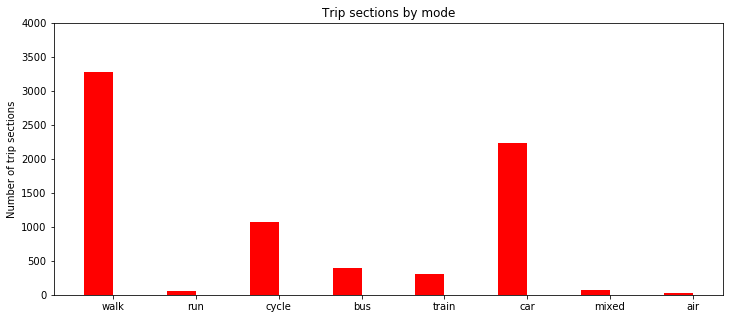

In [13]:
cleanModeNames = {"walking":"walk", "running":"run", "cycling":"cycle"}
(fig, ax) = displayHelpers.showCategoryChart(modeNameList, [modeCountList], ['Confirmed'], ['r'],
                                             "Number of trip sections", "Trip sections by mode", 
                                             cleanNameDict = cleanModeNames, figsize=(12,5))
ax.set_ylim(top=4000)
plt.show()

In [14]:
startTimes = Sections.find({"$and": [{'type': 'move'}, {'confirmed_mode': {'$ne': ''}}]}, {'section_start_datetime': 1, '_id': 0}).sort('section_start_datetime', pymongo.ASCENDING)

In [15]:
nSections = startTimes.count()
print("Starting from %s" % startTimes[0])
print("Ending at %s" % startTimes[nSections-1])
startTime = startTimes[0]['section_start_datetime']
endTime = startTimes[nSections-1]['section_start_datetime']

Starting from {'section_start_datetime': datetime.datetime(2014, 4, 12, 15, 57, 47)}
Ending at {'section_start_datetime': datetime.datetime(2014, 7, 18, 22, 15, 35)}


In [16]:
from datetime import datetime, timedelta

In [17]:
timeNameList = []
timeCountList = []
timeTotalList = []
currTime = startTime
while currTime < endTime:
    currEndTime = currTime + timedelta(days=30)
    if currEndTime > endTime:
        currEndTime = endTime
    currTimeSearch = {'section_start_datetime': {"$gte": currTime, "$lte": currEndTime}}
    nTrips = Sections.find({"$and": [{'type': 'move'}, {'confirmed_mode': {'$ne': ''}}, currTimeSearch]}, {'section_start_datetime': 1, '_id': 0}).count()
    nTotalTrips = Sections.find({"$and": [{'type': 'move'}, currTimeSearch]}, {'section_start_datetime': 1, '_id': 0}).count()
    print("%s - %s = %s, %s" % (currTime.strftime("%m-%d"), currEndTime, nTrips, nTotalTrips))
    timeNameList.append("%s to %s" % (currTime.strftime("%b-%d"), currEndTime.strftime("%b-%d")))
    timeCountList.append(nTrips)
    timeTotalList.append(nTotalTrips)
    currTime = currEndTime

04-12 - 2014-05-12 15:57:47 = 3167, 3921
05-12 - 2014-06-11 15:57:47 = 2715, 4673
06-11 - 2014-07-11 15:57:47 = 1368, 4680
07-11 - 2014-07-18 22:15:35 = 189, 1166


3
len(rectList) = 2, len(countLabelList) = 2


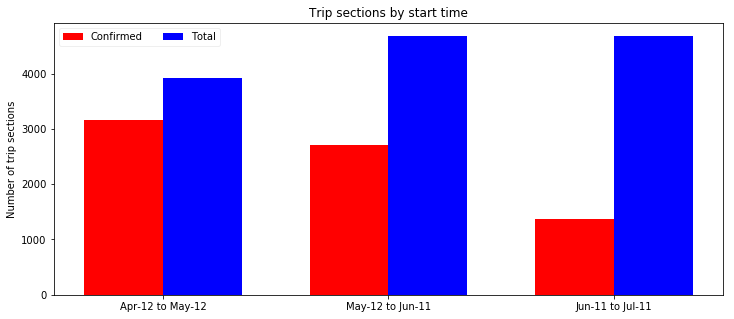

In [18]:
(fig, ax) = displayHelpers.showCategoryChart(timeNameList[:-1], [timeCountList[:-1], timeTotalList[:-1]],
                                             ["Confirmed", "Total"], ['r', 'b'], 
                                             "Number of trip sections", "Trip sections by start time", figsize=(12,5))
# ax.set_ylim(top=5500)
plt.show()

In [19]:
timeNameList = []
timeCountList = []
timeTotalList = []
currTime = datetime(year=2014,month=5,day=6)
while currTime < endTime:
    currTimeSearch = {'section_start_datetime': {"$lte": currTime}}
    nTrips = Sections.find({"$and": [{'type': 'move'}, {'confirmed_mode': {'$ne': ''}}, currTimeSearch]}, {'section_start_datetime': 1, '_id': 0}).count()
    nTotalTrips = Sections.find({"$and": [currTimeSearch]}, {'section_start_datetime': 1, '_id': 0}).count()
    print("%s = %s, %s" % (currTime.strftime("%m-%d"), nTrips, nTotalTrips))
    timeNameList.append("%s" % (currTime.strftime("%b-%d")))
    timeCountList.append(nTrips)
    timeTotalList.append(nTotalTrips)
    currTime = currTime + timedelta(days=7)

05-06 = 2508, 8603
05-13 = 3227, 11892
05-20 = 3974, 15365
05-27 = 4603, 18383
06-03 = 5195, 21629
06-10 = 5776, 25133
06-17 = 6229, 28305
06-24 = 6626, 31257
07-01 = 6882, 34503
07-08 = 7167, 37439
07-15 = 7351, 40357


In [20]:
idList = Sections.find({"$and": [{'type': 'move'}, {'confirmed_mode': {'$ne': ''}}]}).distinct('user_id')
idNameList = []
idCountList = []
confirmedCountList = []
for i, id in enumerate(idList):
    count = Sections.find({"$and": [{'type': 'move'}, {'user_id': id}]}).count()
    confirmedCount = Sections.find({"$and": [{'type': 'move'}, {'confirmed_mode': {'$ne': ''}}, {'user_id': id}]}).count()
    print(id, count, confirmedCount)
    idNameList.append("%s" % i)
    idCountList.append(count)
    confirmedCountList.append(confirmedCount)

01477d94-e0bb-3903-a428-338551801391 117 64
03678a4f-efb9-3100-b0e5-8f296c197eb7 211 211
1a65368b-888e-3e77-8f7c-1128f16da1df 119 22
1c97e50a-aa2a-3016-ad31-f9f6b726d4c4 466 163
1cc03940-57f5-3e35-a189-55d067dc6460 857 164
202a0732-d5c2-307d-aa29-2b39bc5e6660 259 155
2491630e-bb62-39c2-8349-df4dad434dee 138 103
298a1c8e-74c7-3631-b59f-a5ce246c4e6d 410 201
3537737e-8db4-3706-8c6c-ad4cafd9dc82 527 342
399ed209-2e4e-37fc-a6ac-37c25f7ee1f2 133 114
3a307244-ecf1-3e6e-a9a7-3aaf101b40fa 358 296
3b7f6e86-7260-336e-96f0-9e1a0bafc242 679 304
3c1f13e8-b063-3d6c-a1eb-8fd39b874110 113 28
527e98f8-710d-3719-93f2-ab140d1439ba 392 377
5322f635-a82c-3677-a1a4-5c26804a90b7 86 83
560a0ea4-fcdf-3c1b-adf0-22d2b79af3ea 58 5
5c035ff1-e0d5-397f-b989-9cb8faa0a1da 445 444
5dd35f51-3d1a-30db-9b22-ce0a432c2a59 669 465
6a488797-5be1-38aa-9700-5532be978ff9 759 92
7327a0b3-4959-31f5-86cb-ea0c59fd0c83 127 8
89e30222-b446-30ad-852c-b305ddafe70d 339 301
8b3fd099-f3e9-3a8f-a70e-6914ad6b6799 295 287
8d235d9c-7af6-3132-ba

45
len(rectList) = 2, len(countLabelList) = 2


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


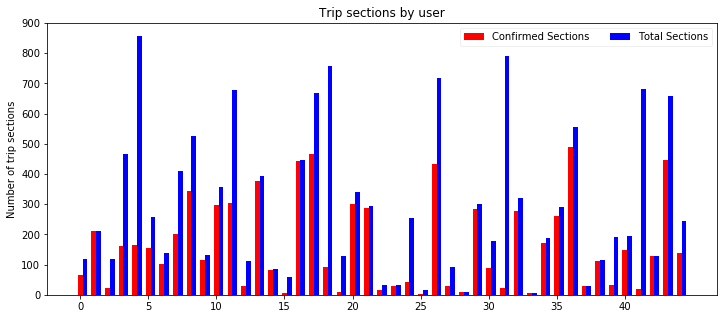

In [21]:
fig, axes = displayHelpers.showCategoryChart(idNameList, [confirmedCountList, idCountList],
                                             ["Confirmed Sections", "Total Sections"],
                                             ['r', 'b'], "Number of trip sections", "Trip sections by user", figsize=(12,5))
oldSize = mpl.rcParams['font.size']
mpl.rcParams['font.size'] = 16
labels = range(0, len(idNameList), 5)
axes.set_xticks(labels)
axes.set_xticklabels(np.array(idNameList)[labels])
fig.show()
mpl.rcParams['font.size'] = oldSize

In [22]:
mpl.rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.mencoder_args': [],
          'animation.mencoder_path': 'mencoder',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'k',
          'axes.facecolor': 'w',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'ax

In [23]:
from featurecalc import calDistance, calSpeed, calHeading, calAvgSpeed, calSpeeds, calAccels, getIthMaxSpeed, getIthMaxAccel, calHCR,\
calSR, calVCR, mode_cluster, mode_start_end_coverage

In [24]:
def getSpeedsForMode(modeId):
    modeSectionCursor = Sections.find({"$and": [{'type': 'move'}, {'confirmed_mode': modeId}]})
    speedList = []
    for section in modeSectionCursor:
        speeds = calSpeeds(section)
        if speeds != None:
            # currHistogram = sp.histogram(speeds)
            speedList.append(speeds)
    return speedList

## Feature matrix construction

In [25]:
# Features are:
# 0. distance
# 1. duration
# 2. first filter mode
# 3. sectionId
# 4. avg speed
# 5. speed EV
# 6. speed variance
# 7. max speed
# 8. max accel
# 9. isCommute
# 10. heading change rate (currently unfilled)
# 11. stop rate (currently unfilled)
# 12. velocity change rate (currently unfilled)
# 13. start lat
# 14. start lng
# 15. stop lat
# 16. stop lng
# 17. start hour
# 18. end hour
# 19. both start and end close to bus stop
# 20. both start and end close to train station
# 21. both start and end close to airport
featureLabels = ["distance", "duration", "first filter mode", "sectionId", "avg speed",
                 "speed EV", "speed variance", "max speed", "max accel", "isCommute",
                 "heading change rate", "stop rate", "velocity change rate", "start lat", "start lng",
                 "stop lat", "stop lng", "start hour", "end hour", "close to bus stop", "close to train stop",
                 "close to airport"]
bus_cluster=mode_cluster(5,105,1)
train_cluster=mode_cluster(6,600,1)
air_cluster=mode_cluster(9,600,1)
def generateFeatureMatrixAndResultVector(sectionQuery):
    confirmedSections = Sections.find(sectionQuery)
    featureMatrix = np.zeros([confirmedSections.count(), len(featureLabels)])
    resultVector = np.zeros(confirmedSections.count())
    for (i, section) in enumerate(confirmedSections):
        featureMatrix[i, 0] = section['distance']
        featureMatrix[i, 1] = (section['section_end_datetime'] - section['section_start_datetime']).total_seconds()
        
        # Deal with unknown modes like "airplane"
        try:
            featureMatrix[i, 2] = section['mode']
        except ValueError:
            featureMatrix[i, 2] = 0
            
        featureMatrix[i, 3] = section['section_id']
        featureMatrix[i, 4] = calAvgSpeed(section)
        speeds = calSpeeds(section)
        if speeds != None:
            featureMatrix[i, 5] = np.mean(speeds)
            featureMatrix[i, 6] = np.std(speeds)
            featureMatrix[i, 7] = np.max(speeds)
        else:
            # They will remain zero
            pass
        accels = calAccels(section)
        if accels != None and len(accels) > 0:
            featureMatrix[i, 8] = np.max(accels)
        else:
            # They will remain zero
            pass
        featureMatrix[i, 9] = ('commute' in section) and (section['commute'] == 'to' or section['commute'] == 'from')
        featureMatrix[i, 10] = calHCR(section)
        featureMatrix[i, 11] = calSR(section)
        featureMatrix[i, 12] = calVCR(section)
        if section['section_start_point'] != None:
            startCoords = section['section_start_point']['coordinates']
            featureMatrix[i, 13] = startCoords[0]
            featureMatrix[i, 14] = startCoords[1]
        
        if section['section_end_point'] != None:
            endCoords = section['section_end_point']['coordinates']
            featureMatrix[i, 15] = endCoords[0]
            featureMatrix[i, 16] = endCoords[1]
        
        featureMatrix[i, 17] = section['section_start_datetime'].time().hour
        featureMatrix[i, 18] = section['section_end_datetime'].time().hour
        
        featureMatrix[i, 19] = mode_start_end_coverage(section,bus_cluster,105)
        featureMatrix[i, 20] = mode_start_end_coverage(section,train_cluster,600)
        featureMatrix[i, 21] = mode_start_end_coverage(section,air_cluster,600)
        resultVector[i] = section['confirmed_mode']
    return (featureMatrix, resultVector)

In [26]:
(featureMatrix, resultVector) = generateFeatureMatrixAndResultVector({"$and": [{'type': 'move'}, {'confirmed_mode': {'$ne': ''}}]})


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [27]:
print(np.max(featureMatrix[:,10]))
print(np.max(featureMatrix[:,20]))
print(np.max(featureMatrix[:,12]))
print(featureMatrix.shape, resultVector.shape)

0.0266343825666
0.0
0.0582191780822
(7439, 22) (7439,)


In [28]:
runIndices = resultVector == 2
transportIndices = resultVector == 4
mixedIndices = resultVector == 8
airIndices = resultVector == 9
unknownIndices = resultVector == 0
strippedIndices = np.logical_not(runIndices | transportIndices | mixedIndices)
print("runIndices = %s" % (np.nonzero(runIndices)))
print("transportIndices = %s" % (np.nonzero(transportIndices)))
print("mixedIndices = %s" % (np.nonzero(mixedIndices)))
print("airIndices = %s" % (np.nonzero(airIndices)))
print("unknownIndices = %s" % (np.nonzero(unknownIndices)))
print("strippedIndices count = %s" % (np.count_nonzero(strippedIndices)))

runIndices = [ 553  590  596 1157 1169 1209 1277 1278 1279 2730 2731 2751 2833 3083 3098
 3107 3119 3120 3129 3135 3157 3169 3181 3192 3194 3225 3232 3238 3239 3248
 3289 3298 3299 3310 3311 3312 3313 3319 3320 3331 3332 3356 3409 3410 4296
 4754 4756 4771 4774 4776 5089 5096 5113 5129 6772 7394]
transportIndices = []
mixedIndices = [ 128  130  159  161  162  250  251  252  253  254  255  257  258  259  260
  261  262  263  264  265  266  267  349  473 1196 1287 1291 2512 2636 5277
 5573 5578 5590 5591 5922 5923 5925 5928 5929 5930 5936 5958 5960 5961 5963
 6567 6593 6693 6698 6743 6818 6819 7046 7047 7048 7050 7051 7052 7058 7059
 7060 7067 7072 7073 7082 7106 7124 7132 7133 7134 7135 7144 7145 7152 7184
 7189]
airIndices = [1403 1779 1808 3784 3872 3919 4900 5900 7105 7125 7126 7127 7128 7129 7131
 7137 7138 7139 7140 7141 7142 7202 7203 7204 7205 7206 7207 7208 7209]
unknownIndices = []
strippedIndices count = 7307


Now, we filter out "mixed" and "running", since there are few instances of them and we don't intend to predict them initially. We also filter out any "transport" since it should never be in the confirmed set, and we don't want to deal with it if it is.

In [29]:
strippedFeatureMatrix = featureMatrix[strippedIndices]
strippedResultVector = resultVector[strippedIndices]

First, we visualize the distribution of some of the features. This is so that we can compare our dataset to Zheng et al 2010.

In [30]:
def plotFeatureVector(featureMatrix, resultVector, featureIndex, modeList):
    avgSpeedFig, avgSpeedAxes = plt.subplots(1,1)
    currModeSpeedsList = []
    currModeNamesList = []
    for mode in modeList:
        currModeMask = resultVector == mode['mode_id']
        currModeSpeeds = featureMatrix[currModeMask, featureIndex]
        # print "For mode %s, shape is %s" % (mode['mode_id'], str(currModeSpeeds.shape))
        if np.count_nonzero(currModeMask) != 0:
            currModeNamesList.append(mode['mode_name'])
            currModeSpeedsList.append(currModeSpeeds)
    avgSpeedAxes.hist(currModeSpeedsList, normed=True, histtype="bar", label=currModeNamesList)
    avgSpeedAxes.set_ylabel("number of segments")
    avgSpeedAxes.set_xlabel(featureLabels[featureIndex])
    plt.legend()

/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


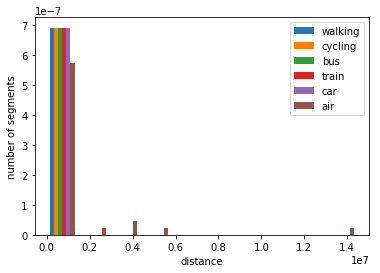

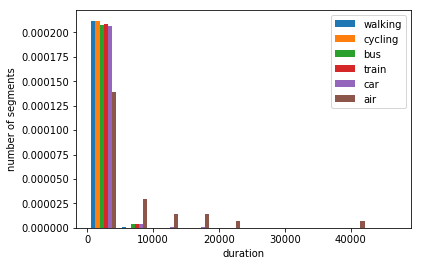

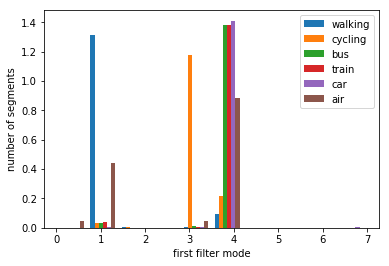

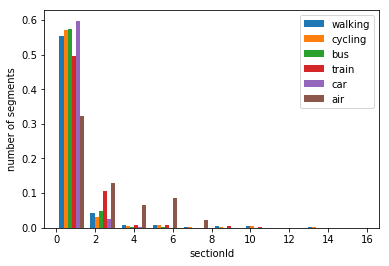

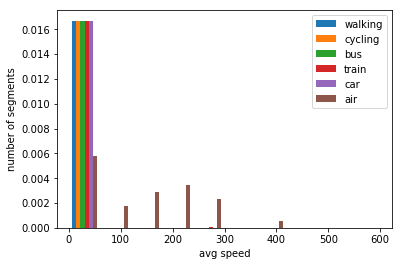

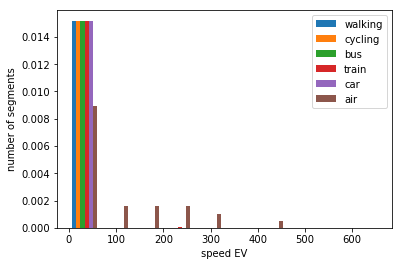

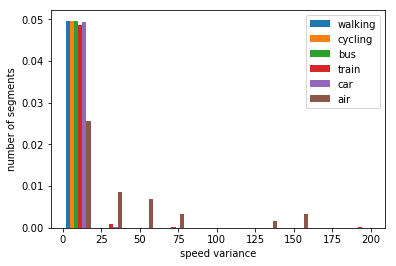

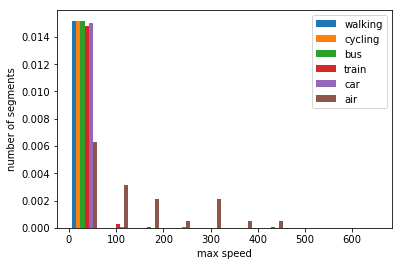

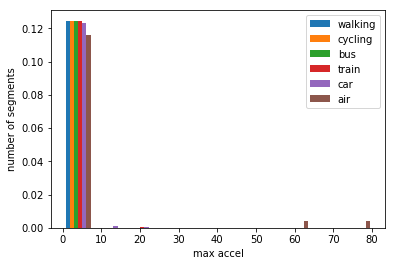

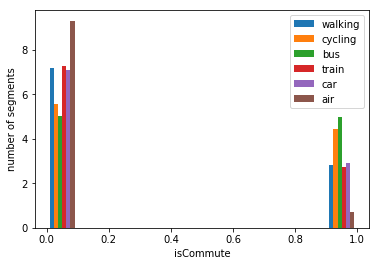

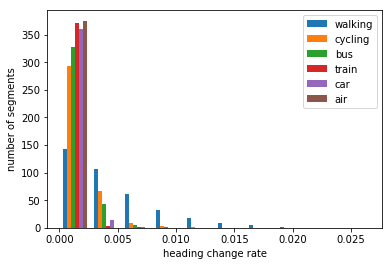

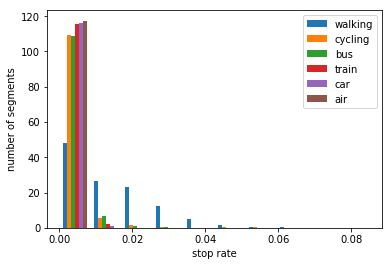

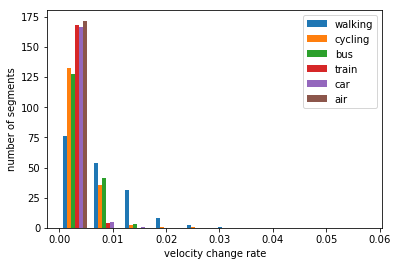

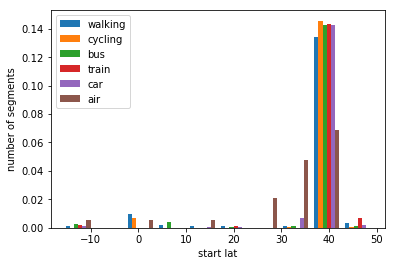

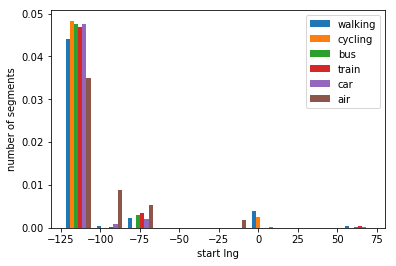

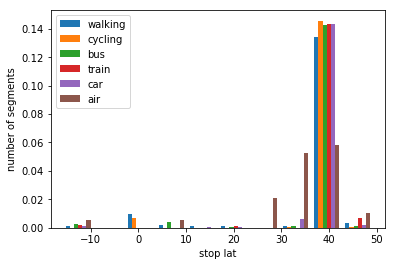

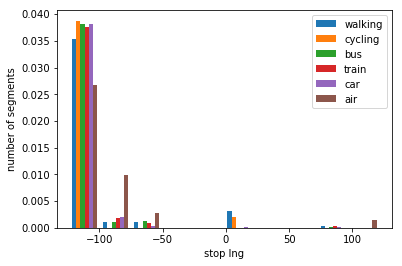

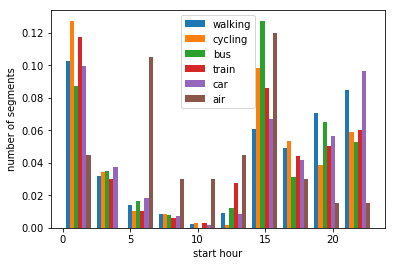

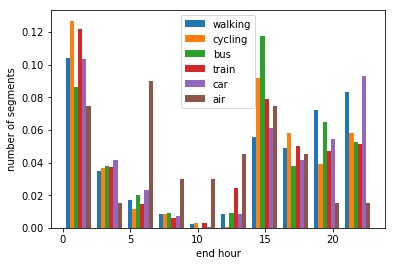

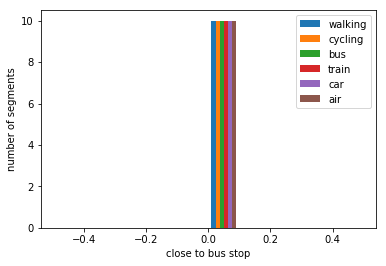

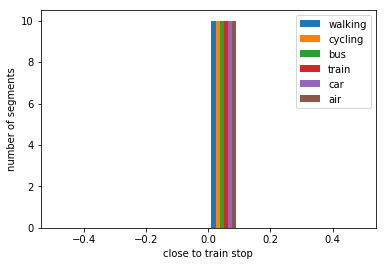

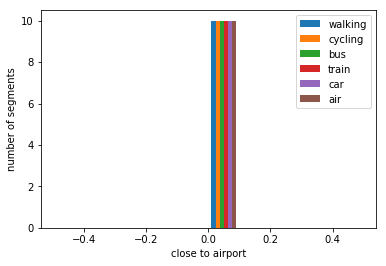

In [31]:
for col in range(0, len(featureLabels)):
    plotFeatureVector(strippedFeatureMatrix, strippedResultVector, col, modeList)

The air modes are such outliers that we are unable to see the variation in the other modes. Let's strip out the outliers and focus on lower speed trips.

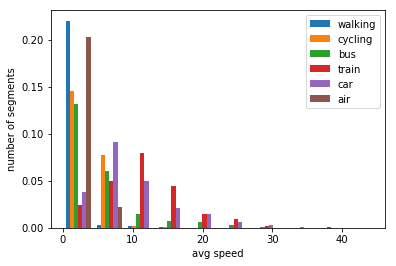

In [32]:
speedNormalEntries = strippedFeatureMatrix[:,4] < 50
plotFeatureVector(strippedFeatureMatrix[speedNormalEntries], strippedResultVector[speedNormalEntries], 4, modeList)

Using the graphs above, we can estimate the separability of our input. Clearly, there is some separability - the car and train trips that are at 20-30+ are clearly separable from the walk/bike trips that are at lower speeds. But are they separable from each other? And at least eyeballing the data, it looks like at least 75% of car trips are actually not that fast - the mean EV is < 10mph. Even with max speed, at least 25% of car trips appear to have a max speed ~ 10 mph. Max accel doesn't seem to have as much predictive power as one might hope - most max accel clusters at less than 5. It would be nice to visualize the clusters in this data, but I'm just going to start trying decision trees and SVMs on this data now.

We used to strip out outliers here, but the outliers actually correspond to plane trips, so we want to retain them. The rest of the code assumes that we stripped outliers to get "cleaned" trips, so we just reassign the values here instead of changing all the code. We can restore outlier detection at that point.

In [33]:
cleanedFeatureMatrix = strippedFeatureMatrix
cleanedResultVector = strippedResultVector

## Feature Indices

In [34]:
genericFeatureIndices = list(range(0,10))
AdvancedFeatureIndices = list(range(10,13))
LocationFeatureIndices = list(range(13,17))
TimeFeatureIndices = list(range(17,19))
BusTrainFeatureIndices = list(range(19,22))
print(genericFeatureIndices)
print(AdvancedFeatureIndices)
print(LocationFeatureIndices)
print(TimeFeatureIndices)
print(BusTrainFeatureIndices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[10, 11, 12]
[13, 14, 15, 16]
[17, 18]
[19, 20, 21]


## Generic model, generic features

In [35]:
genericCleanedFM = cleanedFeatureMatrix[:,genericFeatureIndices]
print(genericCleanedFM.shape)

(7307, 10)


In [36]:
from sklearn import cross_validation
from sklearn import svm

/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [37]:
svmClf = svm.LinearSVC()
svmScores = cross_validation.cross_val_score(svmClf, genericCleanedFM, cleanedResultVector, cv=5)

In [38]:
print(svmScores)
print(svmScores.mean())

[ 0.53278689  0.46653005  0.56262834  0.46369863  0.66255144]
0.537639069423


Using svm.SVC() takes significantly longer (hours instead of seconds) but generates higher accuracy. The accuracy is still lower than the random forest, though.

In [39]:
from sklearn import ensemble

In [40]:
forestClf = ensemble.RandomForestClassifier()
forestScores = cross_validation.cross_val_score(forestClf, genericCleanedFM, cleanedResultVector, cv=5)

In [41]:
print(forestScores)
print(forestScores.mean())

[ 0.81352459  0.83879781  0.86516085  0.83630137  0.79355281]
0.829467487008


These results look pretty good, and pretty much parallel what the Zheng paper got, even with just the basic features. We get 82% average accuracy for a linear SVM and 86% average accuracy for a random forest. But the 82% and 86% values are for cross validation, where we have a known value that we can validate against.

But what we really want to do is to decide, while looking at a section that we have no ground truth on, whether we want the user to classify it or not. And then we want to see, for the high confidence predictions that we will not prompt the user for, how accurate our classification really is.

In order to do this, we get the probabilities for each prediction in addition to the prediction itself. We can then test the accuracy of the high confidence predictions and compare it to the accuracy of all predictions.

To recap, we now return three metrics:

- The number of entries that would be autoclassified given a particular target confidence interval
- The accuracy of the entries that would be autoclassified
- The accuracy of all entries, including ones that had low confidence

In [42]:
# Generate folds of indices
def generateFoldArrays(nIndices, nFolds):
    currPermutation = np.random.permutation(nIndices)
    currPermutationParts = np.array_split(currPermutation, nFolds)
    
    foldArrays = []
    for i in range(0, nFolds):
        testIndices = currPermutationParts[i]
        trainIndicesParts = [currPermutationPart for (j, currPermutationPart) in enumerate(currPermutationParts) if j != i]
        trainIndices = np.concatenate(trainIndicesParts)
        foldArrays.append((trainIndices, testIndices))
    return foldArrays

def kFoldValidationWithProb(algo, X, y, nFolds, prob_threshold):
    foldArrays = generateFoldArrays(len(y), nFolds)
    
    scores = []
    highConfidenceScores = []
    percentAutoClassified = []
    percentAutoClassifiedByMode = []
    for (trainIndices, testIndices) in foldArrays:
        # print testIndices[0]
        model = algo.fit(X[trainIndices], y[trainIndices])
        testX = X[testIndices]
        testy = y[testIndices]
        
        predictedY = model.predict(testX)
        if hasattr(algo, "decision_function"):
            predictedYProb = algo.decision_function(testX)
        else:
            predictedYProb = algo.predict_proba(testX)
        
        # print ("predictedY.shape = %s, predictedYProb.shape = %s" %
        #        (str(predictedY.shape), str(predictedYProb.shape)))
        
        # As we can see below, we take the max confidence along the first axis
        highConfidencePredictions = np.max(predictedYProb, 1) > prob_threshold
        print("Found %s high confidence predictions out of %s" % (np.count_nonzero(highConfidencePredictions),
                                                                  len(testIndices)))
        
        cmc = lambda m:np.count_nonzero(testy[highConfidencePredictions] == m)
        
        # Let us see how many of each mode were autoclassified
        # print("Autoclassifications split by confirmed modes: walk: %s, bike: %s, bus: %s, train: %s, car: %s" %
        #       (cmc(1), cmc(3), cmc(5), cmc(6), cmc(7)))
        
        pcmc = lambda m: float(np.count_nonzero(testy[highConfidencePredictions] == m))/np.count_nonzero(testy == m) if ((np.count_nonzero(testy == m) != 0)) else 0 
        # Let us see what percentage of each mode was autoclassified
        # print("For threshold %s, autoclassifications split by confirmed mode percents: walk: %s, bike: %s, bus: %s, train: %s, car: %s" %
        #        (prob_threshold, pcmc(1), pcmc(3), pcmc(5), pcmc(6), pcmc(7)))
        
        percentAutoClassified.append(float(np.count_nonzero(highConfidencePredictions))/len(testIndices))
        percentAutoClassifiedByMode.append([pcmc(1), pcmc(3), pcmc(5), pcmc(6), pcmc(7), pcmc(9)])
        
        # so now we are going to generate two scores.
        # the first is the score on only the high confidence predictions
        highConfidenceScore = model.score(testX[highConfidencePredictions], testy[highConfidencePredictions])
        highConfidenceScores.append(highConfidenceScore)
        
        score = model.score(X[testIndices], y[testIndices])
        scores.append(score)
    # print scores
    
    print("for prob %s, percentage auto classified %s" % (prob_threshold, np.array(percentAutoClassified).mean()))
    print("for prob %s, scoring only on high confidence predictions %s" % (prob_threshold, np.array(highConfidenceScores).mean()))
    print("for prob %s, scoring on all predictions %s" % (prob_threshold, np.array(scores).mean()))

    return (np.array(percentAutoClassified), np.array(percentAutoClassifiedByMode), np.array(highConfidenceScores), np.array(scores))

In [43]:
def exploreKFoldValidationSpace(algo, X, y, nFolds):
    (pac0, pacm0, hcs0, s0) = kFoldValidationWithProb(algo, X, y, nFolds, 0.90)    
    (pac5, pacm5, hcs5, s5) = kFoldValidationWithProb(algo, X, y, nFolds, 0.95)
    (pac9, pacm9, hcs9, s9) = kFoldValidationWithProb(algo, X, y, nFolds, 0.99)
    
    probs = [0.90, 0.95, 0.99]
    pacs = [pac0.mean(), pac5.mean(), pac9.mean()]
    hcs = [hcs0.mean(), hcs5.mean(), hcs9.mean()]
    ss = [s0.mean(), s5.mean(), s9.mean()]
    
    pacmWalk = [pacm0[:,0].mean(), pacm5[:,0].mean(), pacm9[:,0].mean()]
    pacmBike = [pacm0[:,1].mean(), pacm5[:,1].mean(), pacm9[:,1].mean()]
    pacmBus = [pacm0[:,2].mean(), pacm5[:,2].mean(), pacm9[:,2].mean()]
    pacmTrain = [pacm0[:,3].mean(), pacm5[:,3].mean(), pacm9[:,3].mean()]
    pacmCar = [pacm0[:,4].mean(), pacm5[:,4].mean(), pacm9[:,4].mean()]
    pacmAir = [pacm0[:5].mean(), pacm5[:,5].mean(), pacm9[:,4].mean()]
    
    fig, axes = plt.subplots(1, 1, figsize=(15, 10))
    print(pacs)
    axes.set_yticks(np.arange(0,1,0.1))
    axes.plot(probs, pacs, label="percentage auto classified")
    
    print(pacmWalk)
    axes.plot(probs, pacmWalk, linewidth = 5, label="percent walk auto classified")
    print(pacmBike)
    axes.plot(probs, pacmBike, label="percent bike auto classified")
    print(pacmBus)
    axes.plot(probs, pacmBus, linewidth=5, label="percent bus auto classified")
    print(pacmTrain)
    axes.plot(probs, pacmTrain, label="percent train auto classified")
    print(pacmCar)
    axes.plot(probs, pacmCar, linewidth=5, label="percent car auto classified")
    print(pacmAir)
    axes.plot(probs, pacmAir, linewidth=5, label = "percent air auto classified")
    
    print(hcs)
    axes.plot(probs, hcs, label="accuracy of high confidence samples")
    print(ss)
    axes.plot(probs, ss, linewidth = 5, label="accuracy of all samples")
    plt.legend(loc='best')

Found 804 high confidence predictions out of 1462
Found 776 high confidence predictions out of 1462
Found 759 high confidence predictions out of 1461
Found 763 high confidence predictions out of 1461
Found 755 high confidence predictions out of 1461
for prob 0.9, percentage auto classified 0.527846582977
for prob 0.9, scoring only on high confidence predictions 0.97467661137
for prob 0.9, scoring on all predictions 0.854111223784
Found 758 high confidence predictions out of 1462
Found 740 high confidence predictions out of 1462
Found 777 high confidence predictions out of 1461
Found 749 high confidence predictions out of 1461
Found 784 high confidence predictions out of 1461
for prob 0.95, percentage auto classified 0.521146526516
for prob 0.95, scoring only on high confidence predictions 0.973741723037
for prob 0.95, scoring on all predictions 0.854523118641
Found 774 high confidence predictions out of 1462
Found 766 high confidence predictions out of 1462
Found 801 high confidence pr

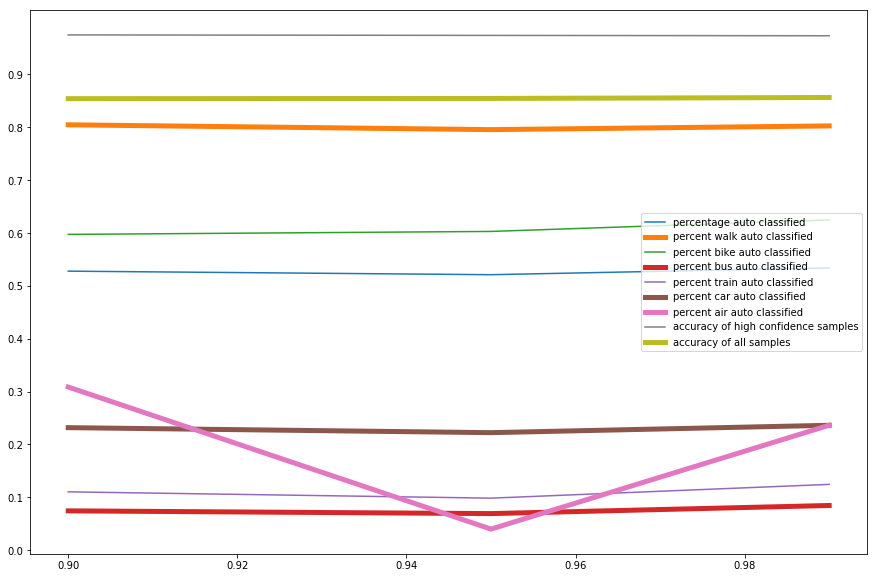

In [44]:
forestClf = ensemble.RandomForestClassifier()
exploreKFoldValidationSpace(forestClf, genericCleanedFM, cleanedResultVector, 5)

The results of these three metrics for confidence intervals of 90%, 95% and 99% are shown above, and they are all largely similar. The accuracy of the high confidence predictions is, as expected, really high at 97 - 98%. However, we were only able to auto-classify ~ 50% of the sections. Now, let's retry using the linear SVM above.

Found 1265 high confidence predictions out of 1462
Found 446 high confidence predictions out of 1462
Found 1122 high confidence predictions out of 1461
Found 404 high confidence predictions out of 1461
Found 741 high confidence predictions out of 1461
for prob 0.9, percentage auto classified 0.544398314218
for prob 0.9, scoring only on high confidence predictions 0.643382926979
for prob 0.9, scoring on all predictions 0.605590122014
Found 1062 high confidence predictions out of 1462
Found 614 high confidence predictions out of 1462
Found 833 high confidence predictions out of 1461
Found 704 high confidence predictions out of 1461
Found 681 high confidence predictions out of 1461
for prob 0.95, percentage auto classified 0.532902618093
for prob 0.95, scoring only on high confidence predictions 0.750810288638
for prob 0.95, scoring on all predictions 0.561645463304
Found 643 high confidence predictions out of 1462
Found 391 high confidence predictions out of 1462
Found 912 high confidenc

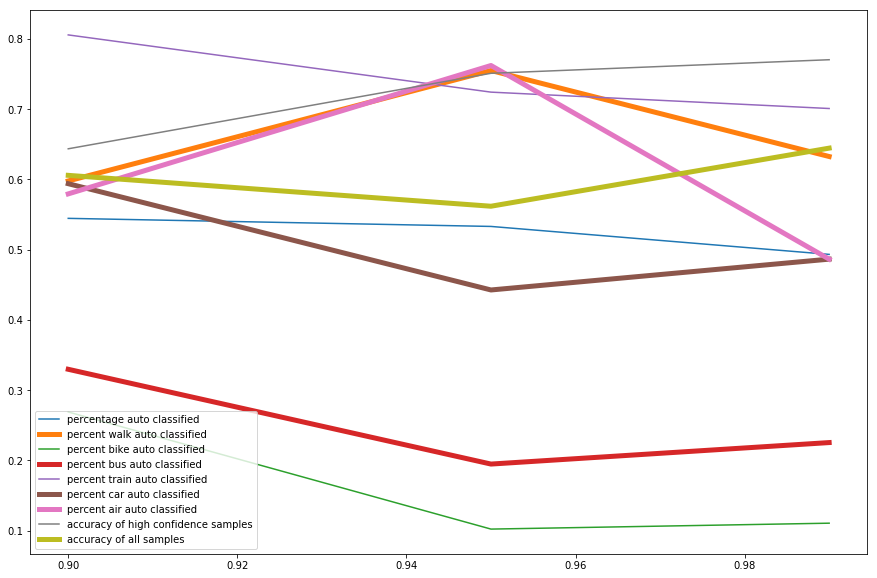

In [45]:
svmClf = svm.LinearSVC()
exploreKFoldValidationSpace(svmClf, genericCleanedFM, cleanedResultVector, 5)

We see that the SVM is able to classify more trips than the decision tree, but at the cost of unacceptably lower performance on the high confidence predictions. It is hard to understand the results with line plots, let's switch to bar graphs instead.

In [46]:
def exploreKFoldValidationSpaceBarGraph(algo, X, y, nFolds):
    (pac0, pacm0, hcs0, s0) = kFoldValidationWithProb(algo, X, y, nFolds, 0.90)    
    (pac5, pacm5, hcs5, s5) = kFoldValidationWithProb(algo, X, y, nFolds, 0.95)
    (pac9, pacm9, hcs9, s9) = kFoldValidationWithProb(algo, X, y, nFolds, 0.99)
    
    probs = [0.90, 0.95, 0.99]
    pacs = [pac0.mean() * 100, pac5.mean() * 100, pac9.mean() * 100]
    hcs = [hcs0.mean() * 100, hcs5.mean() * 100, hcs9.mean() * 100]
    ss = [s0.mean() * 100, s5.mean() * 100, s9.mean() * 100]
    
    mpl.rcParams['font.size'] = 16
    fig, axes = displayHelpers.showCategoryChart(["90%", "95%", "99%"], [pacs, hcs, ss],
                                                       ["% high confidence", "high confidence accuracy", "overall accuracy"],
                                                       ['r', 'g', 'b'], "Percent", "High confidence predictions",
                                                       width=0.15, figsize=(6,5))
    axes.set_yticks(range(0, 100, 10))
    axes.axhline(50, label = "50%")
    axes.axhline(90, label = "90%")
    # axes.get_legend().set_bbox_
    axes.set_ylim(top=100)
    fig.show()

Found 715 high confidence predictions out of 1462
Found 734 high confidence predictions out of 1462
Found 746 high confidence predictions out of 1461
Found 723 high confidence predictions out of 1461
Found 635 high confidence predictions out of 1461
for prob 0.9, percentage auto classified 0.486243517033
for prob 0.9, scoring only on high confidence predictions 0.985758576489
for prob 0.9, scoring on all predictions 0.88189282494
Found 701 high confidence predictions out of 1462
Found 706 high confidence predictions out of 1462
Found 716 high confidence predictions out of 1461
Found 697 high confidence predictions out of 1461
Found 733 high confidence predictions out of 1461
for prob 0.95, percentage auto classified 0.486247449651
for prob 0.95, scoring only on high confidence predictions 0.985937714804
for prob 0.95, scoring on all predictions 0.881347314725
Found 745 high confidence predictions out of 1462
Found 723 high confidence predictions out of 1462
Found 686 high confidence pr

/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


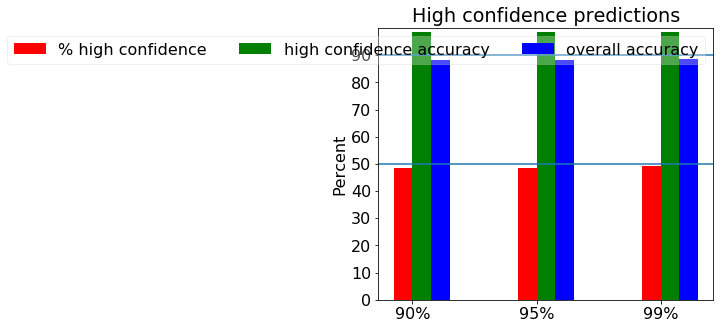

In [47]:
forestClf = ensemble.RandomForestClassifier()
exploreKFoldValidationSpaceBarGraph(forestClf, cleanedFeatureMatrix, cleanedResultVector, 5)

Found 1121 high confidence predictions out of 1462
Found 593 high confidence predictions out of 1462
Found 394 high confidence predictions out of 1461
Found 1360 high confidence predictions out of 1461
Found 579 high confidence predictions out of 1461
for prob 0.9, percentage auto classified 0.553843618532
for prob 0.9, scoring only on high confidence predictions 0.512850091077
for prob 0.9, scoring on all predictions 0.548407055865
Found 843 high confidence predictions out of 1462
Found 819 high confidence predictions out of 1462
Found 307 high confidence predictions out of 1461
Found 874 high confidence predictions out of 1461
Found 765 high confidence predictions out of 1461
for prob 0.95, percentage auto classified 0.49375266271
for prob 0.95, scoring only on high confidence predictions 0.810332720036
for prob 0.95, scoring on all predictions 0.690722393728
Found 1262 high confidence predictions out of 1462
Found 1355 high confidence predictions out of 1462
Found 604 high confidenc

/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


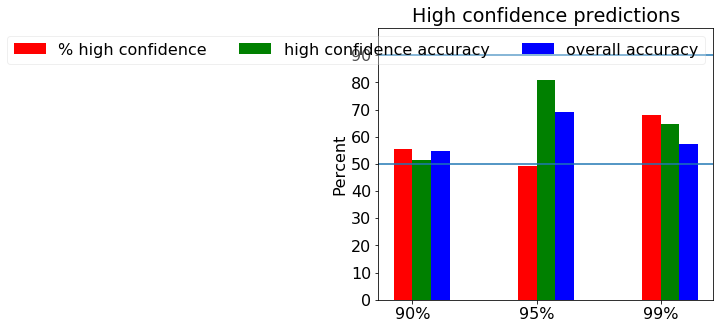

In [48]:
svmClf = svm.LinearSVC()
exploreKFoldValidationSpaceBarGraph(svmClf, cleanedFeatureMatrix, cleanedResultVector, 5)

We now get the most important params for the decision tree so that we can better understand what it is doing.

In [49]:
forestClf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_split': 1e-07,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [50]:
for (i, importance) in enumerate(forestClf.feature_importances_):
    print(featureLabels[i], importance)

distance 0.0410742868716
duration 0.0220718466215
first filter mode 0.230302584374
sectionId 0.0104999251548
avg speed 0.174684512399
speed EV 0.0871829707735
speed variance 0.0974444899536
max speed 0.0286995608278
max accel 0.0222992709551
isCommute 0.00647869028559
heading change rate 0.0418053039276
stop rate 0.0501905023869
velocity change rate 0.0234609141724
start lat 0.0350415502397
start lng 0.0351077068004
stop lat 0.032310289723
stop lng 0.0357251786338
start hour 0.0136034558231
end hour 0.0120169600776
close to bus stop 0.0
close to train stop 0.0
close to airport 0.0


So the highest importance features are:

- first filter mode (moves mode)
- speed EV
- avg speed
- distance

Now, let's try another non-parametric method like nearest neighbor

In [51]:
from sklearn import neighbors

In [52]:
knnClf = neighbors.KNeighborsClassifier()

Found 710 high confidence predictions out of 1462
Found 661 high confidence predictions out of 1462
Found 684 high confidence predictions out of 1461
Found 692 high confidence predictions out of 1461
Found 714 high confidence predictions out of 1461
for prob 0.9, percentage auto classified 0.473656706845
for prob 0.9, scoring only on high confidence predictions 0.91975210439
for prob 0.9, scoring on all predictions 0.753386779477
Found 630 high confidence predictions out of 1462
Found 724 high confidence predictions out of 1462
Found 727 high confidence predictions out of 1461
Found 660 high confidence predictions out of 1461
Found 724 high confidence predictions out of 1461
for prob 0.95, percentage auto classified 0.474205868776
for prob 0.95, scoring only on high confidence predictions 0.924081725881
for prob 0.95, scoring on all predictions 0.756673792195
Found 687 high confidence predictions out of 1462
Found 651 high confidence predictions out of 1462
Found 717 high confidence pr

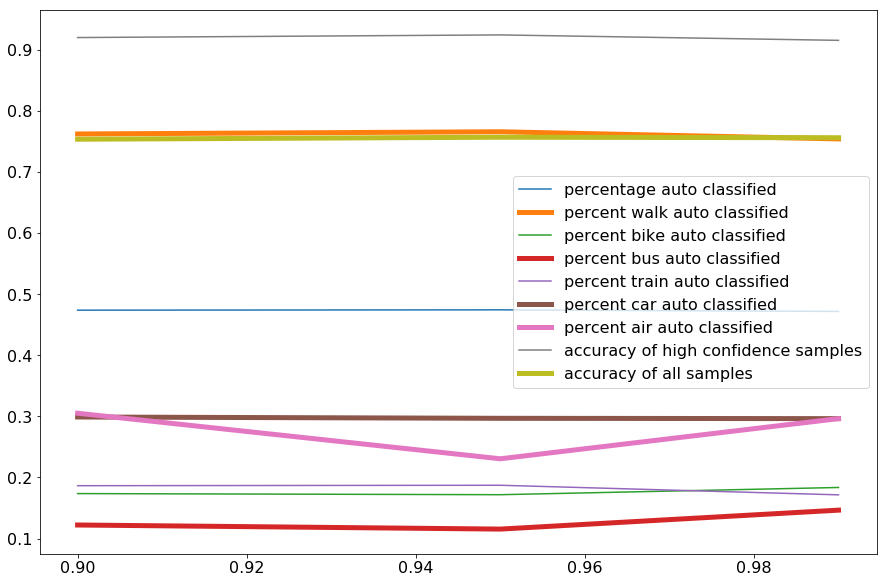

In [53]:
exploreKFoldValidationSpace(knnClf, cleanedFeatureMatrix, cleanedResultVector, 5)

knn does almost the same as decision tree, except that the accuracy of the high confidence predictions is a bit lower.
I think that the percentages are around the same as well. Basically, we can classify walk pretty well and the others pretty poorly.
So I am not sure what we are adding here over moves :)

I'm surprised at the low prediction rate for cycling. Moves seems to get that pretty accurately for me.

I'm now going to plot this data and see what it looks like.

## Advanced features added

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Found 728 high confidence predictions out of 1462
Found 778 high confidence predictions out of 1462
Found 711 high confidence predictions out of 1461
Found 721 high confidence predictions out of 1461
Found 763 high confidence predictions out of 1461
for prob 0.9, percentage auto classified 0.506498275735
for prob 0.9, scoring only on high confidence predictions 0.981667243778
for prob 0.9, scoring on all predictions 0.883536659017
Found 760 high confidence predictions out of 1462
Found 698 high confidence predictions out of 1462
Found 728 high confidence predictions out of 1461
Found 722 high confidence predictions out of 1461
Found 723 high confidence predictions out of 1461
for prob 0.95, percentage auto classified 0.496920292399
for prob 0.95, scoring only on high confidence predictions 0.981569856254
for prob 0.95, scoring on all predictions 0.882716052851
Found 719 high confidence predictions out of 1462
Found 762 

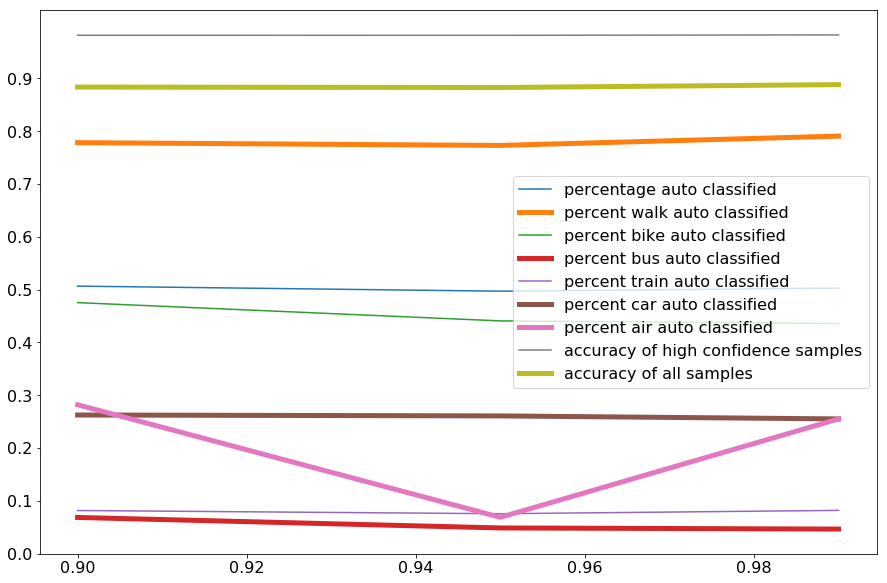

In [54]:
Advanced_indices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
print(Advanced_indices)
forestClf = ensemble.RandomForestClassifier()
exploreKFoldValidationSpace(forestClf, cleanedFeatureMatrix[:,Advanced_indices], cleanedResultVector, 5)

## Spatial knowledge added

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 15, 16, 17, 18, 19, 20]
Found 775 high confidence predictions out of 1462
Found 730 high confidence predictions out of 1462
Found 778 high confidence predictions out of 1461
Found 808 high confidence predictions out of 1461
Found 724 high confidence predictions out of 1461
for prob 0.9, percentage auto classified 0.522104118855
for prob 0.9, scoring only on high confidence predictions 0.983697080266
for prob 0.9, scoring on all predictions 0.88490483534
Found 764 high confidence predictions out of 1462
Found 792 high confidence predictions out of 1462
Found 750 high confidence predictions out of 1461
Found 743 high confidence predictions out of 1461
Found 776 high confidence predictions out of 1461
for prob 0.95, percentage auto classified 0.523468268927
for prob 0.95, scoring only on high confidence predictions 0.985900153535
for prob 0.95, scoring on all predictions 0.889009270677
Found 757 high confidence predictions out of 1462
Found 789 high 

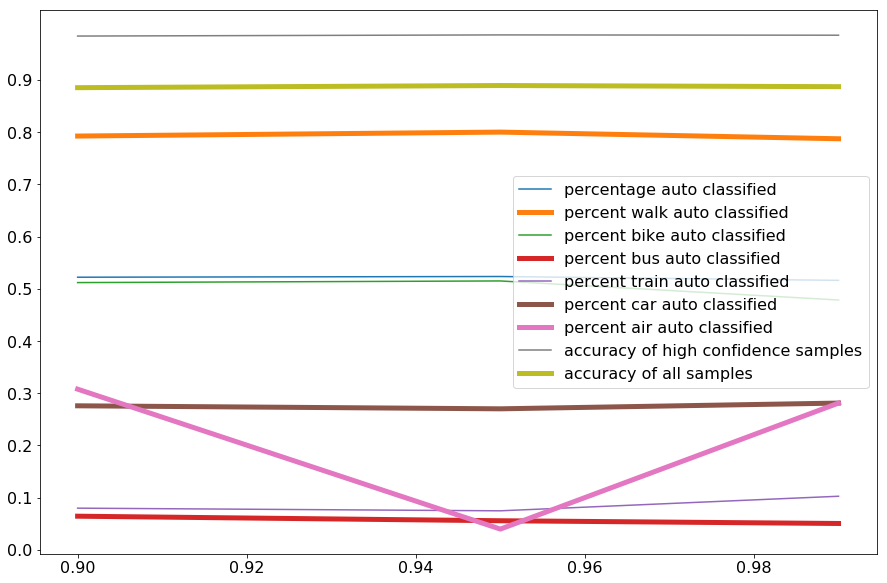

In [55]:
Spatial_indices=[0,1,2,3,4,5,6,7,8,9,13,14,15,16,17,18,19,20]
print(Spatial_indices)
forestClf = ensemble.RandomForestClassifier()
exploreKFoldValidationSpace(forestClf, cleanedFeatureMatrix[:,Spatial_indices], cleanedResultVector, 5)

## Location and time features added

Found 706 high confidence predictions out of 1462
Found 694 high confidence predictions out of 1462
Found 751 high confidence predictions out of 1461
Found 768 high confidence predictions out of 1461
Found 686 high confidence predictions out of 1461
for prob 0.9, percentage auto classified 0.493366517134
for prob 0.9, scoring only on high confidence predictions 0.985733861026
for prob 0.9, scoring on all predictions 0.889009457945
Found 728 high confidence predictions out of 1462
Found 751 high confidence predictions out of 1462
Found 718 high confidence predictions out of 1461
Found 723 high confidence predictions out of 1461
Found 658 high confidence predictions out of 1461
for prob 0.95, percentage auto classified 0.489663021505
for prob 0.95, scoring only on high confidence predictions 0.98592693703
for prob 0.95, scoring on all predictions 0.882989276127
Found 796 high confidence predictions out of 1462
Found 736 high confidence predictions out of 1462
Found 699 high confidence pr

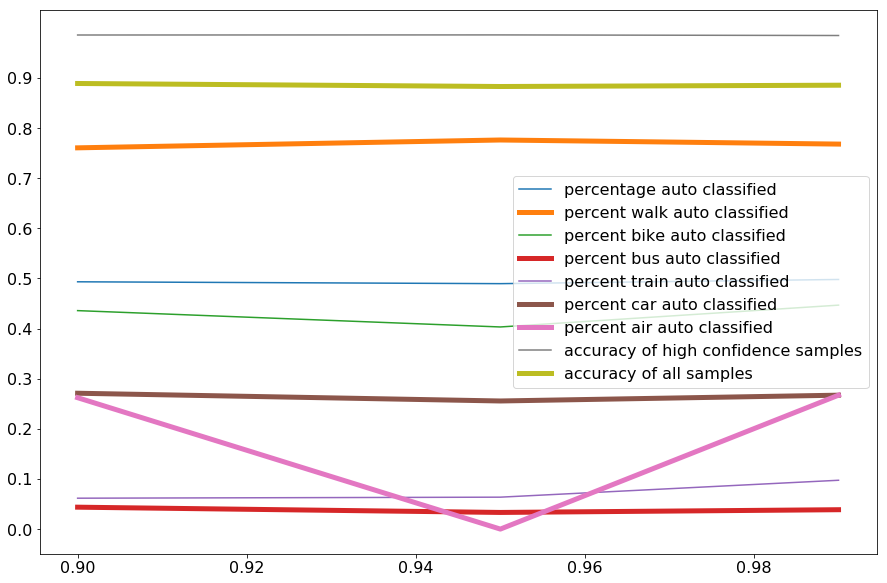

In [56]:
forestClf = ensemble.RandomForestClassifier()
exploreKFoldValidationSpace(forestClf, cleanedFeatureMatrix, cleanedResultVector, 5)

Found 698 high confidence predictions out of 1462
Found 683 high confidence predictions out of 1462
Found 673 high confidence predictions out of 1461
Found 692 high confidence predictions out of 1461
Found 683 high confidence predictions out of 1461
for prob 0.9, percentage auto classified 0.469275209248
for prob 0.9, scoring only on high confidence predictions 0.922347451017
for prob 0.9, scoring on all predictions 0.75749336839
Found 710 high confidence predictions out of 1462
Found 707 high confidence predictions out of 1462
Found 655 high confidence predictions out of 1461
Found 681 high confidence predictions out of 1461
Found 695 high confidence predictions out of 1461
for prob 0.95, percentage auto classified 0.471872796681
for prob 0.95, scoring only on high confidence predictions 0.920737464683
for prob 0.95, scoring on all predictions 0.760503599749
Found 705 high confidence predictions out of 1462
Found 688 high confidence predictions out of 1462
Found 679 high confidence pr

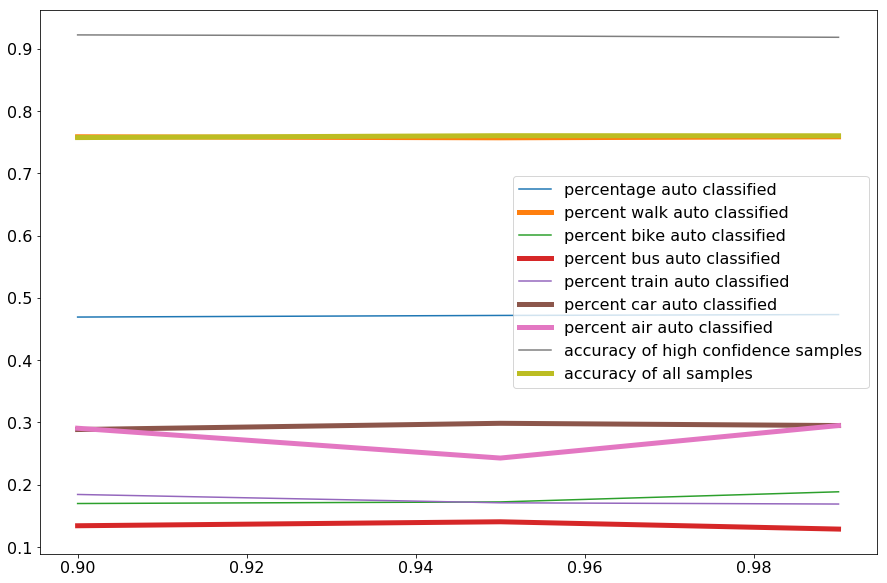

In [57]:
knnClf = neighbors.KNeighborsClassifier()
exploreKFoldValidationSpace(knnClf, cleanedFeatureMatrix, cleanedResultVector, 5)

In [58]:
for (i, importance) in enumerate(forestClf.feature_importances_):
    print(featureLabels[i], importance)

distance 0.0610581573388
duration 0.025508440715
first filter mode 0.251901933681
sectionId 0.0138428984453
avg speed 0.108949011418
speed EV 0.126735121335
speed variance 0.0998651200204
max speed 0.0581331018894
max accel 0.0226698777491
isCommute 0.00479097642193
heading change rate 0.0262546181839
stop rate 0.0225070432192
velocity change rate 0.0306983828318
start lat 0.03016909605
start lng 0.0316502458003
stop lat 0.0293086960919
stop lng 0.0327274481305
start hour 0.0113142880055
end hour 0.0119155426732
close to bus stop 0.0
close to train stop 0.0
close to airport 0.0


## Some more contour plots to help us visualize the data

In [59]:
from matplotlib import colors
import itertools

In [60]:
def printColorMap(algo, Xall, y):
    # we want to split roughly into roughly 10-20 sections
    nSplits = 20
    
    # setup parameters
    cmap_light = colors.ListedColormap(['#FAAAAA', '#AFAAAA', '#AAFAAA', '#AAAFAA', '#AAAAFA', '#AAAAAF'])
    cmap_bold = colors.ListedColormap(['#F00000', '#0F0000', '#00F000', '#000F00', '#0000F0', '#00000F'])
   
    # nFeatures = Xall.shape[1]
    nFeatures = 10
    fig, axes = plt.subplots(20, 5, figsize=(15,50))
    plt.tight_layout()
    axesArr = axes.flatten()
        
    i = 0
    for selCombo in itertools.product(np.arange(nFeatures), np.arange(nFeatures)):
        if selCombo[0] == selCombo[1]:
            continue
        # print("Generating grid for combo %s,%s in slot %s" % (featureLabels[selCombo[0]], featureLabels[selCombo[1]], i))
        
        selMask = np.zeros(Xall.shape[1])
        # Otherwise, we won't be able to plot it properly below
        assert(len(selCombo) == 2)
        selMask[selCombo[0]] = 1
        selMask[selCombo[1]] = 1
    
        X = Xall[:,selMask == 1]
    
        algo.fit(X, y)
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        # we want to split roughly into 
        h_x = float(x_max - x_min) / nSplits
        h_y = float(y_max - y_min) / nSplits
        
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h_x),
                             np.arange(y_min, y_max, h_y))
        Z = algo.predict(np.c_[xx.ravel(), yy.ravel()])
    
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)

        axesArr[i].pcolormesh(xx, yy, Z, cmap=cmap_light)

        # Plot also the training points
        axesArr[i].scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
        # plt.scatter(X[:, 0], X[:, 1], c=y)
        axesArr[i].set_xlim(xx.min(), xx.max())
        axesArr[i].set_ylim(yy.min(), yy.max())
        axesArr[i].set_title("%s v/s %s" % (featureLabels[selCombo[0]], featureLabels[selCombo[1]]))
        # axesArr[i].legend(loc='best')
        i = i+1    

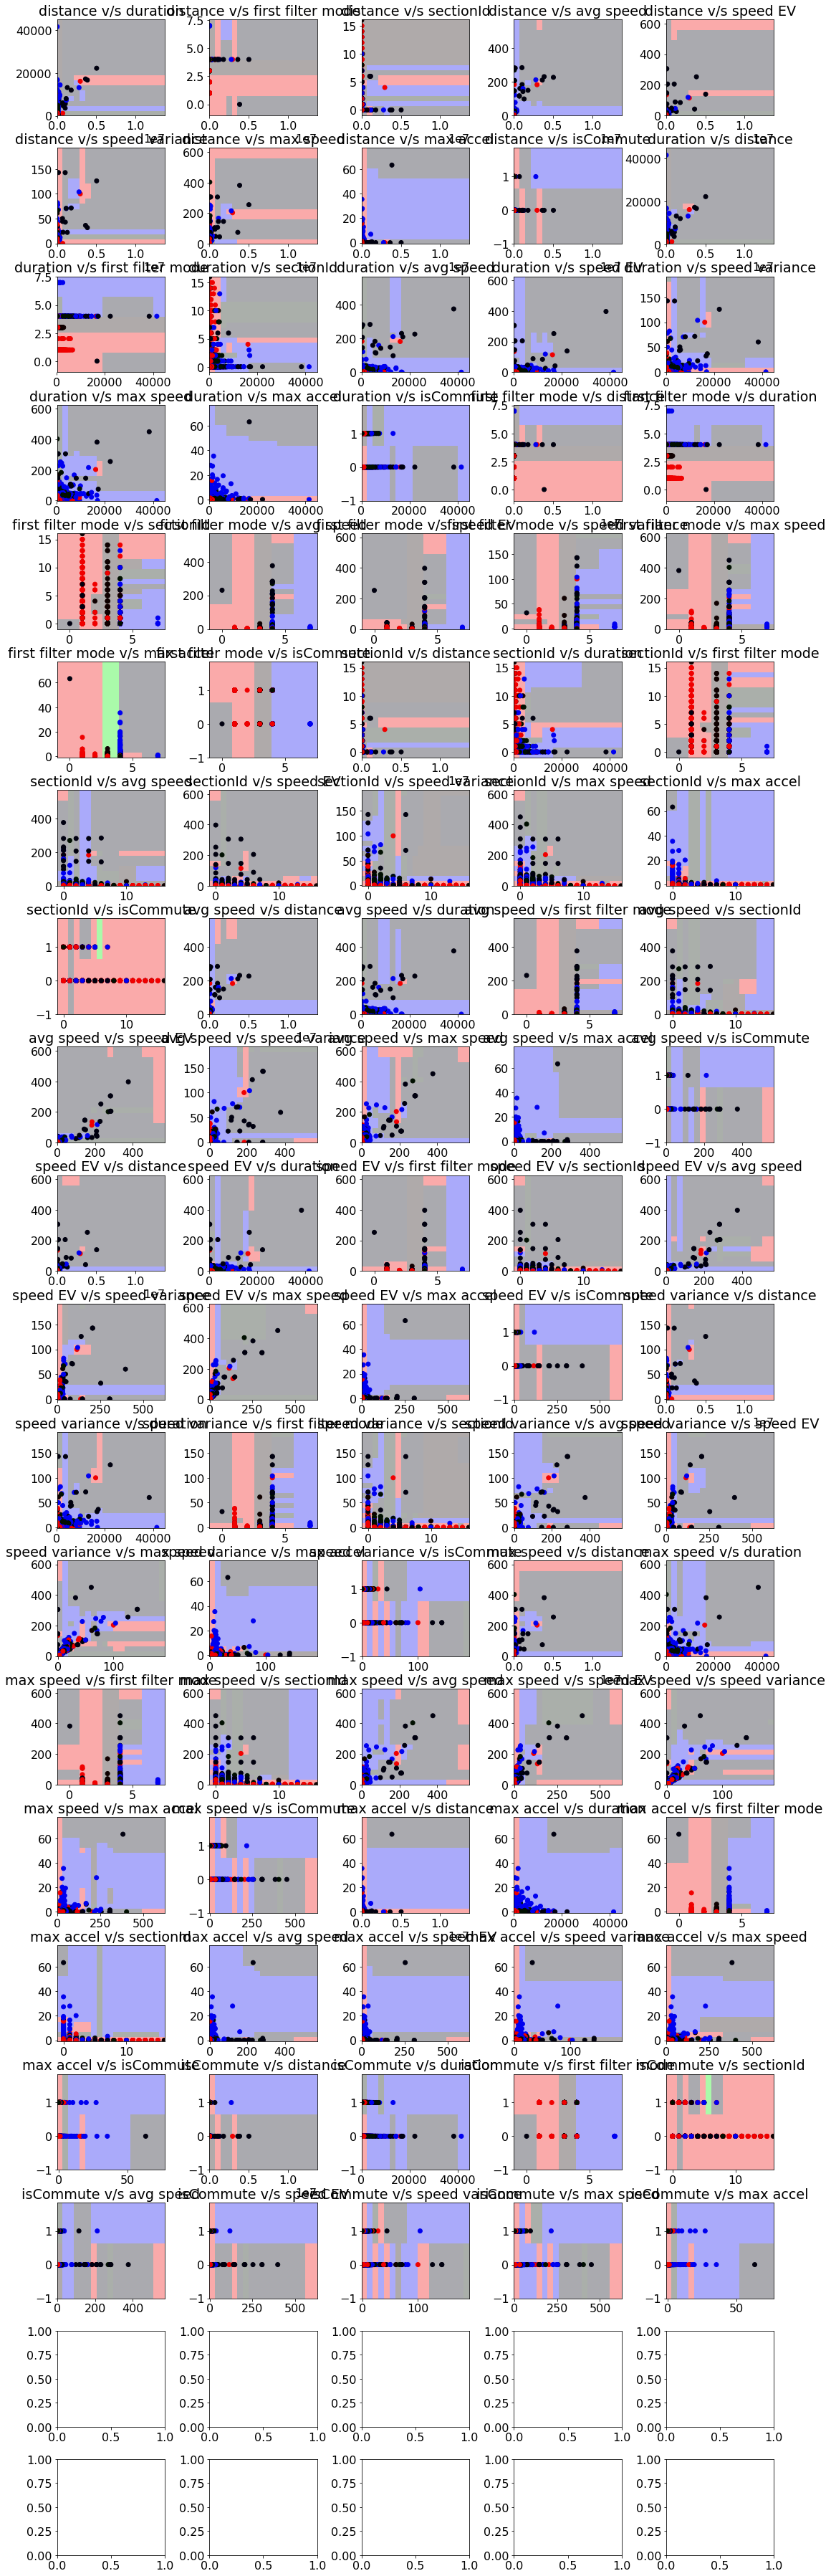

In [61]:
printColorMap(forestClf, cleanedFeatureMatrix, cleanedResultVector)

Let us also quickly take a look at the confusion matrix for the overall model. Because maybe we should not care about the confidence of the predictions, and just weight them lower.

In [62]:
from sklearn import metrics
from matplotlib import cm

In [63]:
def printConfusionMatrix(algo, X, y, title):
    skf = cross_validation.StratifiedKFold(y, 5)
    nClasses = np.count_nonzero(np.unique(y))
    print("nClasses = %s" % nClasses)
    sumPCM = np.zeros([nClasses, nClasses])
    for train, test in skf:
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
        print("Number of distinct classes in training set = %s, test set = %s" % (np.unique(y[train]), np.unique(y[test])))
        y_pred = algo.fit(X_train, y_train).predict(X_test)
        # This has the raw number of entries (e.g. [610  12   1   0  32   1])
        # Since the total number of entries for each mode is different, we want to convert this to a percentage
        cmraw = metrics.confusion_matrix(y_test, y_pred)
        # We do that by summing up the entries for each mode (e.g. 656)
        sumArr = np.sum(cmraw, axis=1)
        # and repeating it across the row (e.g. [656 656 656 656 656 656])
        repeatedSumArr = np.repeat(sumArr, cmraw.shape[1]).reshape(cmraw.shape)
        # And dividing the raw numbers by the sums to get percentages (e.g [92.98 1.82 0 4.87 0.15])
        sumPCM = np.add(sumPCM, np.divide(cmraw.astype(float), repeatedSumArr))
    
    finalPCM = sumPCM / 5
    logFinalPCM = np.log(finalPCM + 1)
    np.set_printoptions(precision=0, suppress=True)
    # np.set_printoptions(precision=4, suppress=False)
    print(finalPCM * 100)

    oldSize = mpl.rcParams['font.size']
    mpl.rcParams['font.size'] = 16
    (fig, ax) = plt.subplots()
    # First element is "" because of http://stackoverflow.com/questions/3529666/matplotlib-matshow-labels
    ax.set_xticklabels(["","walk", "", "bus", "", "car", ""])
    ax.set_yticklabels(["","walk", "cycle", "bus", "train", "car", "air"])
    cax = ax.matshow(logFinalPCM, cmap=cm.gray)
    ax.set_title(title, color='green', weight='bold', size=16, y=1.1)
    
    fig.colorbar(cax)
    ax.set_ylabel('True label', size="large")
    ax.set_xlabel('Predicted label', size="large")
    fig.tight_layout()
    plt.show()
    return (finalPCM, fig)

## Model selection

In [64]:
modelCMList = []
saveDir = "/tmp/ml_results/"

In [65]:
import os
os.makedirs(saveDir, exist_ok=True)

nClasses = 6
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
[[ 95.   1.   0.   0.   3.   0.]
 [  9.  80.   3.   0.   9.   0.]
 [  8.  12.  15.   5.  60.   0.]
 [  5.   1.   5.  27.  62.   0.]
 [  3.   2.   4.   4.  86.   0.]
 [ 25.   7.   0.   7.  13.  49.]]


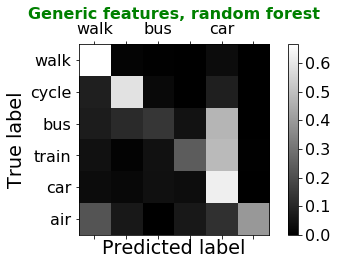

(array([[ 1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]]),
 <matplotlib.figure.Figure at 0x123731908>)

In [66]:
forestClf = ensemble.RandomForestClassifier()
printConfusionMatrix(forestClf, genericCleanedFM, cleanedResultVector, "Generic features, random forest")

nClasses = 6
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
[[ 95.   1.   1.   0.   3.   0.]
 [ 10.  82.   1.   0.   7.   0.]
 [ 10.   5.  29.   3.  54.   0.]
 [  5.   3.   4.  41.  48.   0.]
 [  4.   4.   4.   3.  85.   0.]
 [ 17.   3.   7.   3.  23.  47.]]


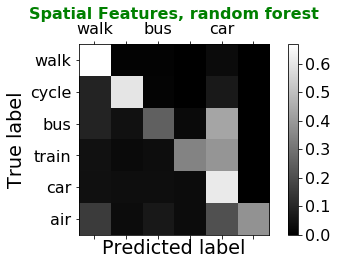

(array([[ 1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]]),
 <matplotlib.figure.Figure at 0x1245569b0>)

In [67]:
forestClf = ensemble.RandomForestClassifier()
printConfusionMatrix(forestClf, cleanedFeatureMatrix[:,Spatial_indices], cleanedResultVector, "Spatial Features, random forest")

nClasses = 6
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
[[ 95.   1.   1.   0.   3.   0.]
 [ 10.  82.   1.   0.   8.   0.]
 [ 10.   4.  33.   3.  49.   0.]
 [  5.   1.   5.  42.  47.   0.]
 [  5.   3.   5.   3.  85.   0.]
 [ 17.   3.   0.  10.  10.  60.]]


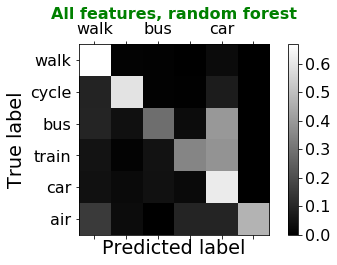

In [68]:
forestClf = ensemble.RandomForestClassifier()
currCM, fig = printConfusionMatrix(forestClf, cleanedFeatureMatrix, cleanedResultVector, "All features, random forest")
fig.savefig(saveDir+"cm_all_random_forest.png", bbox_inches="tight")

Adding start and end points does improve the accuracy of the bus and train. Train trips in particular, are significantly improved.

nClasses = 6
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
[[ 95.   2.   0.   0.   3.   0.]
 [ 15.  50.   5.   0.  29.   0.]
 [ 12.  34.  10.   3.  40.   0.]
 [  6.   6.   3.  16.  69.   0.]
 [  5.  15.   3.   4.  73.   0.]
 [ 32.   0.   0.   4.  27.  37.]]


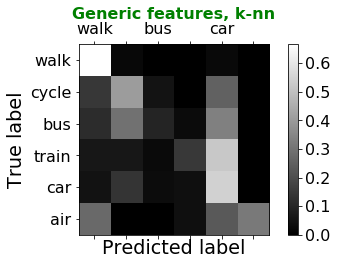

(array([[ 1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]]),
 <matplotlib.figure.Figure at 0x1207d5390>)

In [69]:
knnClf = neighbors.KNeighborsClassifier()
printConfusionMatrix(knnClf, genericCleanedFM, cleanedResultVector, "Generic features, k-nn")

nClasses = 6
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
[[ 95.   2.   0.   0.   2.   0.]
 [ 15.  51.   5.   0.  28.   0.]
 [ 11.  34.  11.   2.  42.   0.]
 [  6.   7.   2.  15.  70.   0.]
 [  5.  15.   3.   4.  73.   0.]
 [ 32.   0.   0.   4.  27.  37.]]


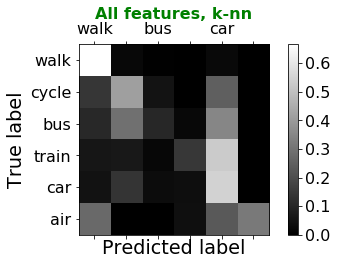

In [70]:
knnClf = neighbors.KNeighborsClassifier()
currCM, fig = printConfusionMatrix(knnClf, cleanedFeatureMatrix, cleanedResultVector, "All features, k-nn")
fig.savefig(saveDir+"cm_all_k_nn.png", bbox_inches="tight")

knn does significantly worse, primarily because of bus trips. I suspect this is because different people make the same trip using different modes. Time for per-user trips?

nClasses = 6
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
[[ 93.   5.   1.   0.   1.   0.]
 [ 26.  24.  18.   0.  32.   0.]
 [ 17.  40.  19.   0.  25.   0.]
 [  8.  34.  19.   0.  39.   0.]
 [  6.  35.  19.   0.  39.   0.]
 [ 20.  24.  17.   0.  24.  15.]]


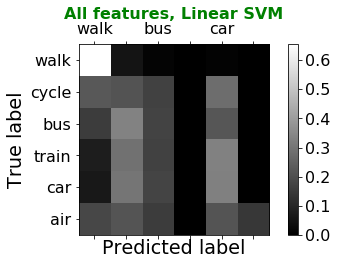

In [71]:
svmClf = svm.LinearSVC()
currCM, fig = printConfusionMatrix(svmClf, cleanedFeatureMatrix, cleanedResultVector, "All features, Linear SVM")
fig.savefig(saveDir+"cm_all_linear_svm.png", bbox_inches="tight")

For parametric models, it is particularly import to tune the parameters correctly. We use the grid_search function from sklearn to find the correct parameters for SVC.

In [72]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


First, we do some coarse tuning on the parameters.

In [73]:
tuned_parameters = [{'C': [0.01, 0.1, 1, 10, 100, 1000],
                     'dual': [True, False],
                     'class_weight' : [None, 'auto']}]
baseClf = svm.LinearSVC()
clf = GridSearchCV(baseClf, tuned_parameters, cv=5)
clf.fit(cleanedFeatureMatrix, cleanedResultVector)
clf.get_params
clf.best_estimator_

/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/sklearn/utils/class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/sklearn/utils/class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/sklearn/utils/class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/sklearn/utils/class_weight.py:65: Depreca

/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/sklearn/utils/class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/sklearn/utils/class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/sklearn/utils/class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/sklearn/utils/class_weight.py:65: Depreca

/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/sklearn/utils/class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/sklearn/utils/class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/sklearn/utils/class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/sklearn/utils/class_weight.py:65: Depreca

LinearSVC(C=100, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Then, we do some fine tuning around the result of the coarse parameter tuning.

In [74]:
tuned_parameters = [{'C': list(range(75, 125, 5))}]
baseClf = svm.LinearSVC()
clf = GridSearchCV(baseClf, tuned_parameters, cv=5)
clf.fit(cleanedFeatureMatrix, cleanedResultVector)
print(clf.get_params)
print(clf.best_estimator_)
print(clf.best_score_)

<bound method BaseEstimator.get_params of GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [75, 80, 85, 90, 95, 100, 105, 110, 115, 120]}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)>
LinearSVC(C=90, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
0.7028876419871356


In [75]:
tuned_parameters = [{'C': list(range(55, 125, 5))}]
baseClf = svm.LinearSVC(dual=False)
clf = GridSearchCV(baseClf, tuned_parameters, cv=5)
clf.fit(cleanedFeatureMatrix, cleanedResultVector)
print(clf.get_params)
print(clf.best_estimator_)
print(clf.best_score_)

<bound method BaseEstimator.get_params of GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)>
LinearSVC(C=100, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
0.7269741343916792


nClasses = 6
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
[[ 91.   1.   0.   0.   7.   0.]
 [ 48.   6.   0.   0.  45.   0.]
 [  4.   0.   0.   0.  96.   0.]
 [  7.   0.   0.   0.  93.   0.]
 [  1.   0.   0.   0.  99.   0.]
 [ 42.   0.   3.   0.  27.  28.]]


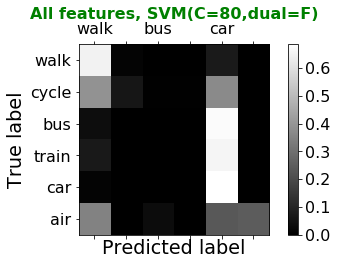

In [76]:
tunedSvmClf = svm.LinearSVC(C=80, dual=False)
currCM, fig = printConfusionMatrix(tunedSvmClf, cleanedFeatureMatrix, cleanedResultVector, "All features, SVM(C=80,dual=F)")
fig.savefig(saveDir+"cm_all_tuned_svm.png", bbox_inches="tight")

In [77]:
from sklearn.kernel_approximation import Nystroem, AdditiveChi2Sampler, RBFSampler, SkewedChi2Sampler
from sklearn.linear_model import SGDClassifier
from sklearn.lda import LDA
from sklearn import preprocessing

/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


nClasses = 6
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
[[ 77.   4.   1.   0.  17.   0.]
 [ 18.  58.   2.   0.  22.   0.]
 [ 31.  14.   5.   1.  48.   0.]
 [ 38.   4.   2.   1.  56.   0.]
 [ 24.   5.   3.   1.  67.   0.]
 [ 51.  15.   0.   0.  34.   0.]]


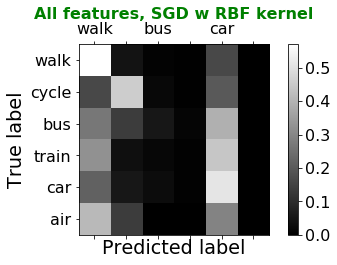

In [78]:
rbf_feature = RBFSampler()
cleanedFeatureMatrix_features = rbf_feature.fit_transform(preprocessing.scale(cleanedFeatureMatrix))
sgdClf = SGDClassifier()
currCM, fig = printConfusionMatrix(sgdClf, cleanedFeatureMatrix_features, cleanedResultVector, "All features, SGD w RBF kernel")
fig.savefig(saveDir+"cm_all_rbf_kernel_sgd.png", bbox_inches="tight")

nClasses = 6
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
[[ 86.   3.   1.   2.   9.   0.]
 [ 23.  54.   3.   1.  18.   0.]
 [ 22.  13.   4.   3.  57.   1.]
 [ 26.   4.   5.   5.  60.   0.]
 [ 20.   6.   2.   2.  70.   0.]
 [ 68.   7.   3.   7.  15.   0.]]


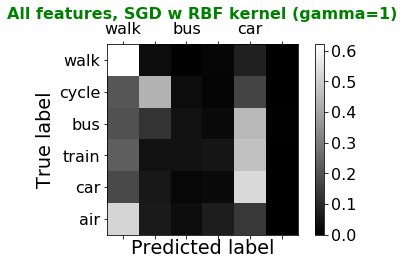

(array([[ 1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.]]),
 <matplotlib.figure.Figure at 0x12694b828>)

In [79]:
rbf_feature = RBFSampler(gamma=1)
cleanedFeatureMatrix_features = rbf_feature.fit_transform(preprocessing.scale(cleanedFeatureMatrix))
sgdClf = SGDClassifier()
printConfusionMatrix(sgdClf, cleanedFeatureMatrix_features, cleanedResultVector, "All features, SGD w RBF kernel (gamma=1)")

nClasses = 6
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
[[ 79.   5.   1.   1.  14.   0.]
 [ 25.  55.   3.   1.  16.   0.]
 [ 35.  11.  12.   2.  41.   0.]
 [ 38.   3.   2.   4.  51.   2.]
 [ 22.   4.   4.   2.  68.   0.]
 [ 46.  13.   0.   3.  37.   0.]]


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


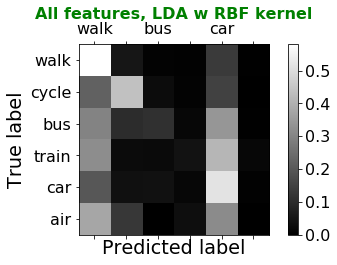

In [80]:
rbf_feature = RBFSampler()
cleanedFeatureMatrix_features = rbf_feature.fit_transform(preprocessing.scale(cleanedFeatureMatrix))
ldaClf = LDA()
currCM, fig = printConfusionMatrix(ldaClf, cleanedFeatureMatrix_features, cleanedResultVector, "All features, LDA w RBF kernel")
fig.savefig(saveDir+"cm_all_rbf_kernel_lda.png", bbox_inches="tight")

nClasses = 6
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
[[ 83.   4.   0.   0.  13.   0.]
 [ 25.  61.   0.   0.  14.   0.]
 [ 44.   6.   1.   0.  49.   0.]
 [ 38.   5.   1.   0.  56.   0.]
 [ 25.   3.   0.   0.  71.   0.]
 [ 55.  11.   0.   0.  34.   0.]]


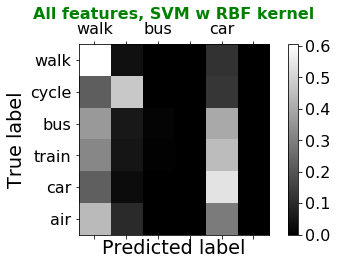

In [81]:
rbf_feature = RBFSampler()
cleanedFeatureMatrix_features = rbf_feature.fit_transform(preprocessing.scale(cleanedFeatureMatrix))
linearSVMClf = svm.LinearSVC()
currCM, fig = printConfusionMatrix(linearSVMClf, cleanedFeatureMatrix_features, cleanedResultVector, "All features, SVM w RBF kernel")
fig.savefig(saveDir+"cm_all_rbf_kernel_svm.png", bbox_inches="tight")

nClasses = 6
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
[[ 92.   2.   1.   0.   5.   0.]
 [  7.  77.   2.   1.  14.   0.]
 [  5.  14.  13.   2.  66.   0.]
 [  5.   5.   2.   8.  79.   1.]
 [  2.   5.   5.   4.  83.   2.]
 [ 25.   7.  13.   3.   3.  48.]]


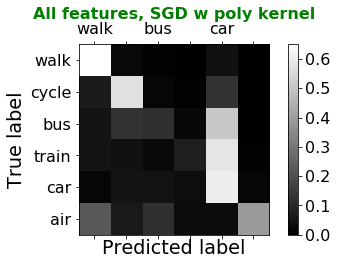

In [82]:
nys_feature = Nystroem(kernel='polynomial')
cleanedFeatureMatrix_features = nys_feature.fit_transform(preprocessing.scale(cleanedFeatureMatrix))
sgdClf = SGDClassifier()
currCM, fig = printConfusionMatrix(sgdClf, cleanedFeatureMatrix_features, cleanedResultVector, "All features, SGD w poly kernel")
fig.savefig(saveDir+"cm_all_poly_kernel_sgd.png", bbox_inches="tight")

nClasses = 6
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


[[ 92.   1.   1.   0.   5.   0.]
 [  4.  81.   5.   2.   8.   0.]
 [  2.   5.  35.   7.  50.   0.]
 [  3.   1.   5.  32.  59.   0.]
 [  0.   1.   8.   7.  84.   0.]
 [ 20.  19.   0.  10.   0.  51.]]


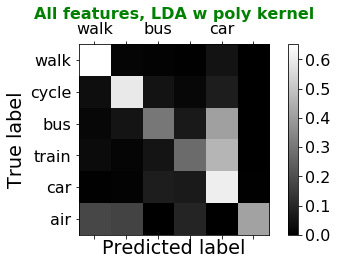

In [83]:
nys_feature = Nystroem(kernel='polynomial')
cleanedFeatureMatrix_features = nys_feature.fit_transform(preprocessing.scale(cleanedFeatureMatrix))
ldaClf = LDA()
currCM, fig = printConfusionMatrix(ldaClf, cleanedFeatureMatrix_features, cleanedResultVector, "All features, LDA w poly kernel")
fig.savefig(saveDir+"cm_all_poly_kernel_lda.png", bbox_inches="tight")

nClasses = 6
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
[[ 92.   1.   0.   0.   6.   0.]
 [  6.  80.   2.   0.  12.   0.]
 [  2.   5.  11.   2.  81.   0.]
 [  4.   2.   2.   8.  84.   0.]
 [  1.   1.   2.   1.  96.   0.]
 [ 24.  10.   3.  10.  11.  42.]]


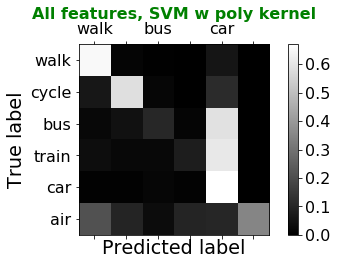

In [84]:
nys_feature = Nystroem(kernel='polynomial')
cleanedFeatureMatrix_features = nys_feature.fit_transform(preprocessing.scale(cleanedFeatureMatrix))
svmClf = svm.LinearSVC()
currCM, fig = printConfusionMatrix(svmClf, cleanedFeatureMatrix_features, cleanedResultVector, "All features, SVM w poly kernel")
fig.savefig(saveDir+"cm_all_poly_kernel_svm.png", bbox_inches="tight")

nClasses = 6
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
[[ 94.   1.   0.   0.   4.   0.]
 [ 12.  69.   0.   0.  18.   0.]
 [  4.  21.   3.   2.  69.   1.]
 [  6.   3.   1.   9.  80.   1.]
 [  2.   6.   1.   2.  88.   1.]
 [ 41.   7.   0.   0.   3.  49.]]


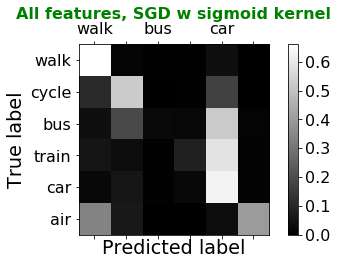

In [85]:
nys_feature = Nystroem(kernel='sigmoid')
cleanedFeatureMatrix_features = nys_feature.fit_transform(preprocessing.scale(cleanedFeatureMatrix))
sgdClf = SGDClassifier()
currCM, fig = printConfusionMatrix(sgdClf, cleanedFeatureMatrix_features, cleanedResultVector, "All features, SGD w sigmoid kernel")
fig.savefig(saveDir+"cm_all_sigmoid_kernel_sgd.png", bbox_inches="tight")

nClasses = 6
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


[[ 92.   2.   1.   0.   5.   0.]
 [  5.  82.   6.   0.   7.   0.]
 [  2.   9.  35.   5.  49.   0.]
 [  3.   1.   4.  31.  61.   0.]
 [  1.   2.   8.   7.  83.   0.]
 [ 13.  14.   0.  10.   3.  59.]]


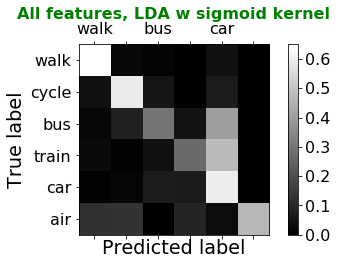

In [86]:
nys_feature = Nystroem(kernel='sigmoid')
cleanedFeatureMatrix_features = nys_feature.fit_transform(preprocessing.scale(cleanedFeatureMatrix))
ldaClf = LDA()
currCM, fig = printConfusionMatrix(ldaClf, cleanedFeatureMatrix_features, cleanedResultVector, "All features, LDA w sigmoid kernel")
fig.savefig(saveDir+"cm_all_sigmoid_kernel_lda.png", bbox_inches="tight")

nClasses = 6
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
[[ 93.   1.   0.   0.   5.   0.]
 [  8.  79.   2.   0.  11.   0.]
 [  2.   9.   8.   0.  80.   0.]
 [  4.   2.   1.   5.  88.   0.]
 [  1.   1.   1.   0.  97.   0.]
 [ 17.  18.   7.   0.  10.  49.]]


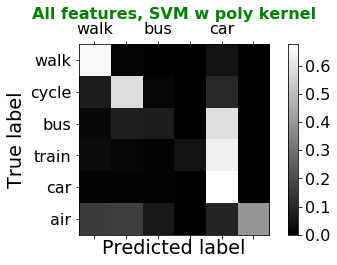

In [87]:
nys_feature = Nystroem(kernel='sigmoid')
cleanedFeatureMatrix_features = nys_feature.fit_transform(preprocessing.scale(cleanedFeatureMatrix))
svmClf = svm.LinearSVC()
currCM, fig = printConfusionMatrix(svmClf, cleanedFeatureMatrix_features, cleanedResultVector, "All features, SVM w poly kernel")
fig.savefig(saveDir+"cm_all_sigmoid_kernel_svm.png", bbox_inches="tight")

In [88]:
# nys_feature = Nystroem(kernel='chi2')
# cleanedFeatureMatrix_features = nys_feature.fit_transform(preprocessing.scale(cleanedFeatureMatrix))
# sgdClf = SGDClassifier()
# printConfusionMatrix(sgdClf, cleanedFeatureMatrix_features, cleanedResultVector, "All features, SGD w sigmoid kernel")

### Only for transport trips

As we can see, the prediction rate is best for walk and bike, which are the ones for which we get the most data from moves. It may be a mistake to use the same model for both types of trips because moves will do a good job for walk/bike and a horrible job for transport, because we don't allow users to specify 'transport' in the output.

These also have zero carbon footprint. Let us see how well we do on the motorized trips alone.

In [89]:
transportTrips = cleanedFeatureMatrix[:,2] == 4
print(np.count_nonzero(transportTrips))

3280


nClasses = 6
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
[[ 32.   8.   7.   5.  47.   1.]
 [ 11.  12.  20.   0.  57.   0.]
 [  4.   7.  21.   3.  64.   0.]
 [  3.   1.   3.  23.  69.   0.]
 [  3.   2.   6.   3.  86.   0.]
 [  5.   0.   0.   0.  28.  67.]]


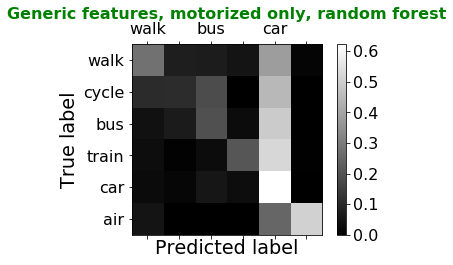

(array([[ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.]]),
 <matplotlib.figure.Figure at 0x12030a518>)

In [90]:
forestClf = ensemble.RandomForestClassifier()
printConfusionMatrix(forestClf, genericCleanedFM[transportTrips], cleanedResultVector[transportTrips], "Generic features, motorized only, random forest")

nClasses = 6
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
[[ 28.   6.  11.   4.  50.   0.]
 [ 10.  24.  11.   1.  55.   0.]
 [  7.   3.  30.   5.  55.   0.]
 [  2.   0.   5.  43.  50.   0.]
 [  3.   2.   4.   4.  87.   0.]
 [  5.   0.   0.   0.  23.  72.]]


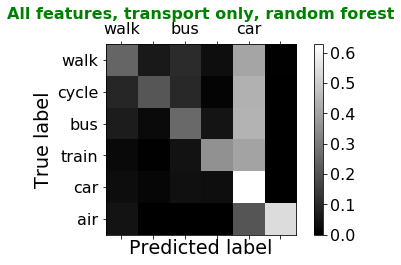

(array([[ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.]]),
 <matplotlib.figure.Figure at 0x120c42e48>)

In [91]:
forestClf = ensemble.RandomForestClassifier()
printConfusionMatrix(forestClf, cleanedFeatureMatrix[transportTrips], cleanedResultVector[transportTrips], "All features, transport only, random forest")

nClasses = 6
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
[[ 31.   6.  10.   3.  49.   1.]
 [ 22.  11.  19.   1.  48.   0.]
 [  8.   5.  24.   3.  60.   0.]
 [  1.   1.   5.  18.  75.   0.]
 [  3.   2.   6.   4.  84.   0.]
 [  0.   0.   0.   7.  45.  48.]]


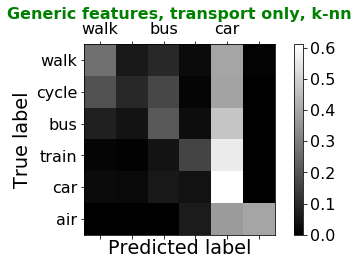

(array([[ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]]),
 <matplotlib.figure.Figure at 0x12268ba90>)

In [92]:
knnClf = neighbors.KNeighborsClassifier()
printConfusionMatrix(knnClf, genericCleanedFM[transportTrips], cleanedResultVector[transportTrips], "Generic features, transport only, k-nn")

nClasses = 6
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
Number of distinct classes in training set = [ 1.  3.  5.  6.  7.  9.], test set = [ 1.  3.  5.  6.  7.  9.]
[[ 32.   8.  12.   2.  46.   1.]
 [ 20.  14.  22.   0.  44.   0.]
 [  8.   5.  24.   2.  61.   0.]
 [  1.   1.   4.  17.  77.   0.]
 [  3.   2.   6.   4.  84.   0.]
 [  0.   0.   0.   7.  45.  48.]]


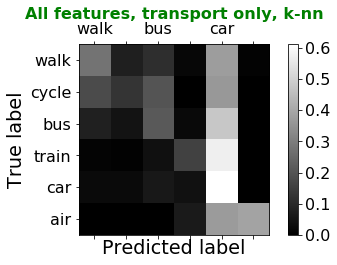

(array([[ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]]),
 <matplotlib.figure.Figure at 0x120e8a208>)

In [93]:
knnClf = neighbors.KNeighborsClassifier()
printConfusionMatrix(knnClf, cleanedFeatureMatrix[transportTrips], cleanedResultVector[transportTrips], "All features, transport only, k-nn")

As we can see, we are actually able to predict car trips with a fair degree of accuracy. But bus and train trips are pretty much a tossup. Ignore the entries for 0 and 1 above, since we stripped out all walk and bike trips, and so these are only trips which moves misclassified, and not the entire dataset. Now we know why the Zheng paper only attempted to distinguish between bus and car trips, and not bus, train and car. The new features helped in the decision tree case, but not by that much, and did not help us at all in the knn case.

## User-specific models

In [94]:
def getUserModelComparison(isTransportOnly):
    userIds = Sections.distinct("user_id")

    # I'm not going to bother with testing against only the generic features
    # because the main issue here is personalization

    userIdList = []
    numberOfSections = []
    percentWalkBikeSections = []
    percentAutoClassified = []
    percentAutoClassifiedWalk = []
    percentAutoClassifiedBike = []
    percentAutoClassifiedBus = []
    percentAutoClassifiedTrain = []
    percentAutoClassifiedCar = []
    autoClassifiedAccuracy = []
    overallAccuracy = []

    labels = ["Number of sections", "% walk+bike trips",
              "% autoclassified", "% auto classified walk",
              "% auto classified bike", "% auto classified bus",
              "% auto classified train", "% auto classified car",
              "auto classified accuracy", "overall accuracy"]
    
    for userId in userIds:
        # decision tree with all features
        if not isTransportOnly:
            query = {"$and": [{'type': 'move'}, {'confirmed_mode': {'$ne': ''}}, {'user_id': userId}]}
        else:
            query = {"$and": [{'type': 'move'}, {'confirmed_mode': {'$ne': ''}}, {'mode': 4}, {'user_id': userId}]}
        
        wbQuery = {"$and": [{'type': 'move'}, {'confirmed_mode': {'$in': ['1', '3', '7']}}, {'user_id': userId}]}
        walkBikeTripCount = Sections.find(wbQuery).count()
        (userFeatureMatrix, userResultVector) = generateFeatureMatrixAndResultVector(query)
    
        # we only focus on users who have enough history with us
        if len(userResultVector) < 150:
            print("Skipping user with userId %s who has %s unconfirmed sections" % (userId, len(userResultVector)))
            continue
        
        forestClf = ensemble.RandomForestClassifier()
        # printConfusionMatrix(forestClf, userFeatureMatrix, userResultVector)
        (pac5, pacm5, hcs5, s5) = kFoldValidationWithProb(forestClf, userFeatureMatrix, userResultVector, 5, 0.95)
        userIdList.append(userId)
        
        numberOfSections.append(len(userResultVector))
        percentWalkBikeSections.append(float(walkBikeTripCount)/len(userResultVector))
        percentAutoClassified.append(pac5.mean())
        percentAutoClassifiedWalk.append(pacm5[0].mean())
        percentAutoClassifiedBike.append(pacm5[1].mean())
        percentAutoClassifiedBus.append(pacm5[2].mean())
        percentAutoClassifiedTrain.append(pacm5[3].mean())
        percentAutoClassifiedCar.append(pacm5[4].mean())
        autoClassifiedAccuracy.append(hcs5.mean())
        overallAccuracy.append(s5.mean())
    resultArray = np.array([numberOfSections, percentAutoClassified, percentAutoClassifiedWalk,
                            percentAutoClassifiedBike, percentAutoClassifiedBus, percentAutoClassifiedTrain,
                            percentAutoClassifiedCar, autoClassifiedAccuracy, overallAccuracy])
    print(resultArray.shape)
    return (userIdList, resultArray, labels)

In [95]:
def displayUserVariation(userIds, ra, labels):
    ''' ra has rows = plots and cols = users
    '''
    fig, (axes, axesNum) = plt.subplots(2, 1, figsize=(25, 25))
    nUsers = len(userIds)
    
    for i in [1,-2,-1]:
        # each row is one plot
        print(ra[i])
        axes.plot(np.arange(nUsers), ra[i], linewidth=2, label=labels[i])
        axes.legend(loc='best')
    for i in [0]:
        # each row is one plot
        print(ra[i])
        axesNum.plot(np.arange(nUsers), ra[i], linewidth=2, label=labels[i])    
        axesNum.legend(loc='best')

In [96]:
(userIds, userResultArray, labels) = getUserModelComparison(isTransportOnly=False)

/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Skipping user with userId 01477d94-e0bb-3903-a428-338551801391 who has 64 unconfirmed sections
Found 11 high confidence predictions out of 43
Found 15 high confidence predictions out of 42
Found 11 high confidence predictions out of 42
Found 14 high confidence predictions out of 42
Found 14 high confidence predictions out of 42
for prob 0.95, percentage auto classified 0.308305647841
for prob 0.95, scoring only on high confidence predictions 1.0
for prob 0.95, scoring on all predictions 0.876965669989
Skipping user with userId 04a9dec3-5a20-38ef-85b7-414dc7a2cf4e who has 0 unconfirmed sections


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Skipping user with userId 1a65368b-888e-3e77-8f7c-1128f16da1df who has 22 unconfirmed sections
Found 24 high confidence predictions out of 33
Found 23 high confidence predictions out of 33
Found 29 high confidence predictions out of 33
Found 22 high confidence predictions out of 32
Found 31 high confidence predictions out of 32
for prob 0.95, percentage auto classified 0.791856060606
for prob 0.95, scoring only on high confidence predictions 0.986206896552
for prob 0.95, scoring on all predictions 0.975378787879


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Found 13 high confidence predictions out of 33
Found 12 high confidence predictions out of 33
Found 15 high confidence predictions out of 33
Found 14 high confidence predictions out of 33
Found 15 high confidence predictions out of 32
for prob 0.95, percentage auto classified 0.421022727273
for prob 0.95, scoring only on high confidence predictions 0.986666666667
for prob 0.95, scoring on all predictions 0.87178030303


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Found 24 high confidence predictions out of 31
Found 28 high confidence predictions out of 31
Found 22 high confidence predictions out of 31
Found 23 high confidence predictions out of 31
Found 24 high confidence predictions out of 31
for prob 0.95, percentage auto classified 0.78064516129
for prob 0.95, scoring only on high confidence predictions 1.0
for prob 0.95, scoring on all predictions 0.974193548387


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Skipping user with userId 2491630e-bb62-39c2-8349-df4dad434dee who has 103 unconfirmed sections
Found 19 high confidence predictions out of 41
Found 25 high confidence predictions out of 40
Found 21 high confidence predictions out of 40
Found 27 high confidence predictions out of 40
Found 21 high confidence predictions out of 40
for prob 0.95, percentage auto classified 0.562682926829
for prob 0.95, scoring only on high confidence predictions 0.992592592593
for prob 0.95, scoring on all predictions 0.860609756098


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Found 49 high confidence predictions out of 69
Found 42 high confidence predictions out of 69
Found 48 high confidence predictions out of 68
Found 42 high confidence predictions out of 68
Found 39 high confidence predictions out of 68
for prob 0.95, percentage auto classified 0.643179880648
for prob 0.95, scoring only on high confidence predictions 0.973979591837
for prob 0.95, scoring on all predictions 0.926939471441


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Skipping user with userId 399ed209-2e4e-37fc-a6ac-37c25f7ee1f2 who has 114 unconfirmed sections
Found 29 high confidence predictions out of 60
Found 24 high confidence predictions out of 59
Found 33 high confidence predictions out of 59
Found 24 high confidence predictions out of 59
Found 31 high confidence predictions out of 59
for prob 0.95, percentage auto classified 0.476327683616
for prob 0.95, scoring only on high confidence predictions 0.981036168133
for prob 0.95, scoring on all predictions 0.895254237288


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Found 28 high confidence predictions out of 61
Found 32 high confidence predictions out of 61
Found 30 high confidence predictions out of 61
Found 34 high confidence predictions out of 61
Found 22 high confidence predictions out of 60
for prob 0.95, percentage auto classified 0.479890710383
for prob 0.95, scoring only on high confidence predictions 0.968651960784
for prob 0.95, scoring on all predictions 0.865300546448


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Skipping user with userId 3c1f13e8-b063-3d6c-a1eb-8fd39b874110 who has 28 unconfirmed sections
Found 39 high confidence predictions out of 76
Found 38 high confidence predictions out of 76
Found 33 high confidence predictions out of 75
Found 42 high confidence predictions out of 75
Found 42 high confidence predictions out of 75
for prob 0.95, percentage auto classified 0.514631578947
for prob 0.95, scoring only on high confidence predictions 1.0
for prob 0.95, scoring on all predictions 0.896631578947


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Skipping user with userId 5322f635-a82c-3677-a1a4-5c26804a90b7 who has 83 unconfirmed sections
Skipping user with userId 560a0ea4-fcdf-3c1b-adf0-22d2b79af3ea who has 5 unconfirmed sections
Found 39 high confidence predictions out of 89
Found 36 high confidence predictions out of 89
Found 35 high confidence predictions out of 89
Found 44 high confidence predictions out of 89
Found 40 high confidence predictions out of 88
for prob 0.95, percentage auto classified 0.436976506639
for prob 0.95, scoring only on high confidence predictions 0.990454545455
for prob 0.95, scoring on all predictions 0.900970377937


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Found 65 high confidence predictions out of 93
Found 63 high confidence predictions out of 93
Found 70 high confidence predictions out of 93
Found 63 high confidence predictions out of 93
Found 67 high confidence predictions out of 93
for prob 0.95, percentage auto classified 0.705376344086
for prob 0.95, scoring only on high confidence predictions 1.0
for prob 0.95, scoring on all predictions 0.939784946237


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Skipping user with userId 6a488797-5be1-38aa-9700-5532be978ff9 who has 92 unconfirmed sections
Skipping user with userId 6dbe9b5a-26a1-31d0-aeb6-7b08ffa49b10 who has 0 unconfirmed sections
Skipping user with userId 7327a0b3-4959-31f5-86cb-ea0c59fd0c83 who has 8 unconfirmed sections
Skipping user with userId 7a88d272-3b9e-3d18-9749-57ddb6214440 who has 0 unconfirmed sections
Found 32 high confidence predictions out of 61
Found 22 high confidence predictions out of 60
Found 25 high confidence predictions out of 60
Found 25 high confidence predictions out of 60
Found 27 high confidence predictions out of 60
for prob 0.95, percentage auto classified 0.434918032787
for prob 0.95, scoring only on high confidence predictions 0.990909090909
for prob 0.95, scoring on all predictions 0.824043715847


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Found 37 high confidence predictions out of 58
Found 39 high confidence predictions out of 58
Found 43 high confidence predictions out of 57
Found 33 high confidence predictions out of 57
Found 43 high confidence predictions out of 57
for prob 0.95, percentage auto classified 0.679612825166
for prob 0.95, scoring only on high confidence predictions 0.974857700439
for prob 0.95, scoring on all predictions 0.937265577737


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Skipping user with userId 8d235d9c-7af6-3132-ba91-626e40181449 who has 16 unconfirmed sections
Skipping user with userId 8d718272-c46c-3e24-8bae-9696917deeec who has 28 unconfirmed sections
Skipping user with userId 8e230f78-6e37-3588-bf2c-6888a5b63c82 who has 43 unconfirmed sections
Skipping user with userId 951779de-a10c-3373-b186-c1c9b14b5e38 who has 3 unconfirmed sections
Found 47 high confidence predictions out of 87
Found 46 high confidence predictions out of 87
Found 42 high confidence predictions out of 87
Found 55 high confidence predictions out of 86
Found 44 high confidence predictions out of 86
for prob 0.95, percentage auto classified 0.540577385726
for prob 0.95, scoring only on high confidence predictions 0.982503574132
for prob 0.95, scoring on all predictions 0.902993851911


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Skipping user with userId 9cc9d577-3a22-3659-8cd5-9142936f44ec who has 29 unconfirmed sections
Skipping user with userId a1a10092-0136-37f1-8109-9ebf47ef72b2 who has 8 unconfirmed sections
Found 36 high confidence predictions out of 57
Found 26 high confidence predictions out of 57
Found 29 high confidence predictions out of 57
Found 30 high confidence predictions out of 57
Found 42 high confidence predictions out of 57
for prob 0.95, percentage auto classified 0.571929824561
for prob 0.95, scoring only on high confidence predictions 1.0
for prob 0.95, scoring on all predictions 0.975438596491


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Skipping user with userId acd105e3-b221-35c5-81ac-fee5ffe9de66 who has 89 unconfirmed sections
Skipping user with userId adaa57a8-7fb8-3389-acce-db50ddc9e2dd who has 24 unconfirmed sections
Found 18 high confidence predictions out of 56
Found 23 high confidence predictions out of 56
Found 18 high confidence predictions out of 56
Found 19 high confidence predictions out of 56
Found 23 high confidence predictions out of 55
for prob 0.95, percentage auto classified 0.362207792208
for prob 0.95, scoring only on high confidence predictions 0.991304347826
for prob 0.95, scoring on all predictions 0.92474025974
Skipping user with userId b3b9fe85-d510-3e5b-bec2-031ca9da7c83 who has 0 unconfirmed sections
Skipping user with userId bbd4e1ad-bd2d-3126-a58c-2c2fe1895fba who has 0 unconfirmed sections


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Skipping user with userId bcbefbfc-8021-353f-9f5c-648d539c8cff who has 5 unconfirmed sections
Found 14 high confidence predictions out of 34
Found 10 high confidence predictions out of 34
Found 21 high confidence predictions out of 34
Found 23 high confidence predictions out of 34
Found 23 high confidence predictions out of 34
for prob 0.95, percentage auto classified 0.535294117647
for prob 0.95, scoring only on high confidence predictions 1.0
for prob 0.95, scoring on all predictions 0.905882352941


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Found 17 high confidence predictions out of 53
Found 10 high confidence predictions out of 52
Found 18 high confidence predictions out of 52
Found 20 high confidence predictions out of 52
Found 20 high confidence predictions out of 52
for prob 0.95, percentage auto classified 0.325689404935
for prob 0.95, scoring only on high confidence predictions 0.96
for prob 0.95, scoring on all predictions 0.842960812772


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Found 17 high confidence predictions out of 98
Found 14 high confidence predictions out of 98
Found 20 high confidence predictions out of 98
Found 24 high confidence predictions out of 97
Found 16 high confidence predictions out of 97
for prob 0.95, percentage auto classified 0.186555859457
for prob 0.95, scoring only on high confidence predictions 0.955616246499
for prob 0.95, scoring on all predictions 0.782726698927


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Skipping user with userId d8a6b737-b6a5-3fc7-a144-76ac2d434252 who has 28 unconfirmed sections
Skipping user with userId e0509a4e-9842-3c73-8050-875b6383c097 who has 112 unconfirmed sections
Skipping user with userId e1a99120-9a5a-31ae-9d7a-93b9a3e0c51c who has 32 unconfirmed sections
Skipping user with userId e211dd91-423f-31ff-a1f8-89e5fdecc164 who has 148 unconfirmed sections
Skipping user with userId ea3f7719-f4a3-36fd-9477-924114cfe0bd who has 18 unconfirmed sections
Skipping user with userId ed8ca6a2-9092-37af-adde-46e51a18a310 who has 128 unconfirmed sections
Found 29 high confidence predictions out of 90
Found 26 high confidence predictions out of 89
Found 32 high confidence predictions out of 89
Found 30 high confidence predictions out of 89
Found 36 high confidence predictions out of 89
for prob 0.95, percentage auto classified 0.343096129838
for prob 0.95, scoring only on high confidence predictions 0.96202991453
for prob 0.95, scoring on all predictions 0.82279650437


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Skipping user with userId f8fee20c-0f32-359d-ba75-bce97a7ac83b who has 137 unconfirmed sections
Skipping user with userId fb457463-9a06-3c84-947d-db1fefb5a199 who has 0 unconfirmed sections
Skipping user with userId ff860db0-f3fe-387c-a005-c5837f5ba970 who has 0 unconfirmed sections
(9, 20)


[ 0.  1.  0.  1.  1.  1.  0.  0.  1.  0.  1.  0.  1.  1.  1.  0.  1.  0.
  0.  0.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.]
[ 211.  163.  164.  155.  201.  342.  296.  304.  377.  444.  465.  301.
  287.  433.  285.  279.  170.  261.  488.  446.]


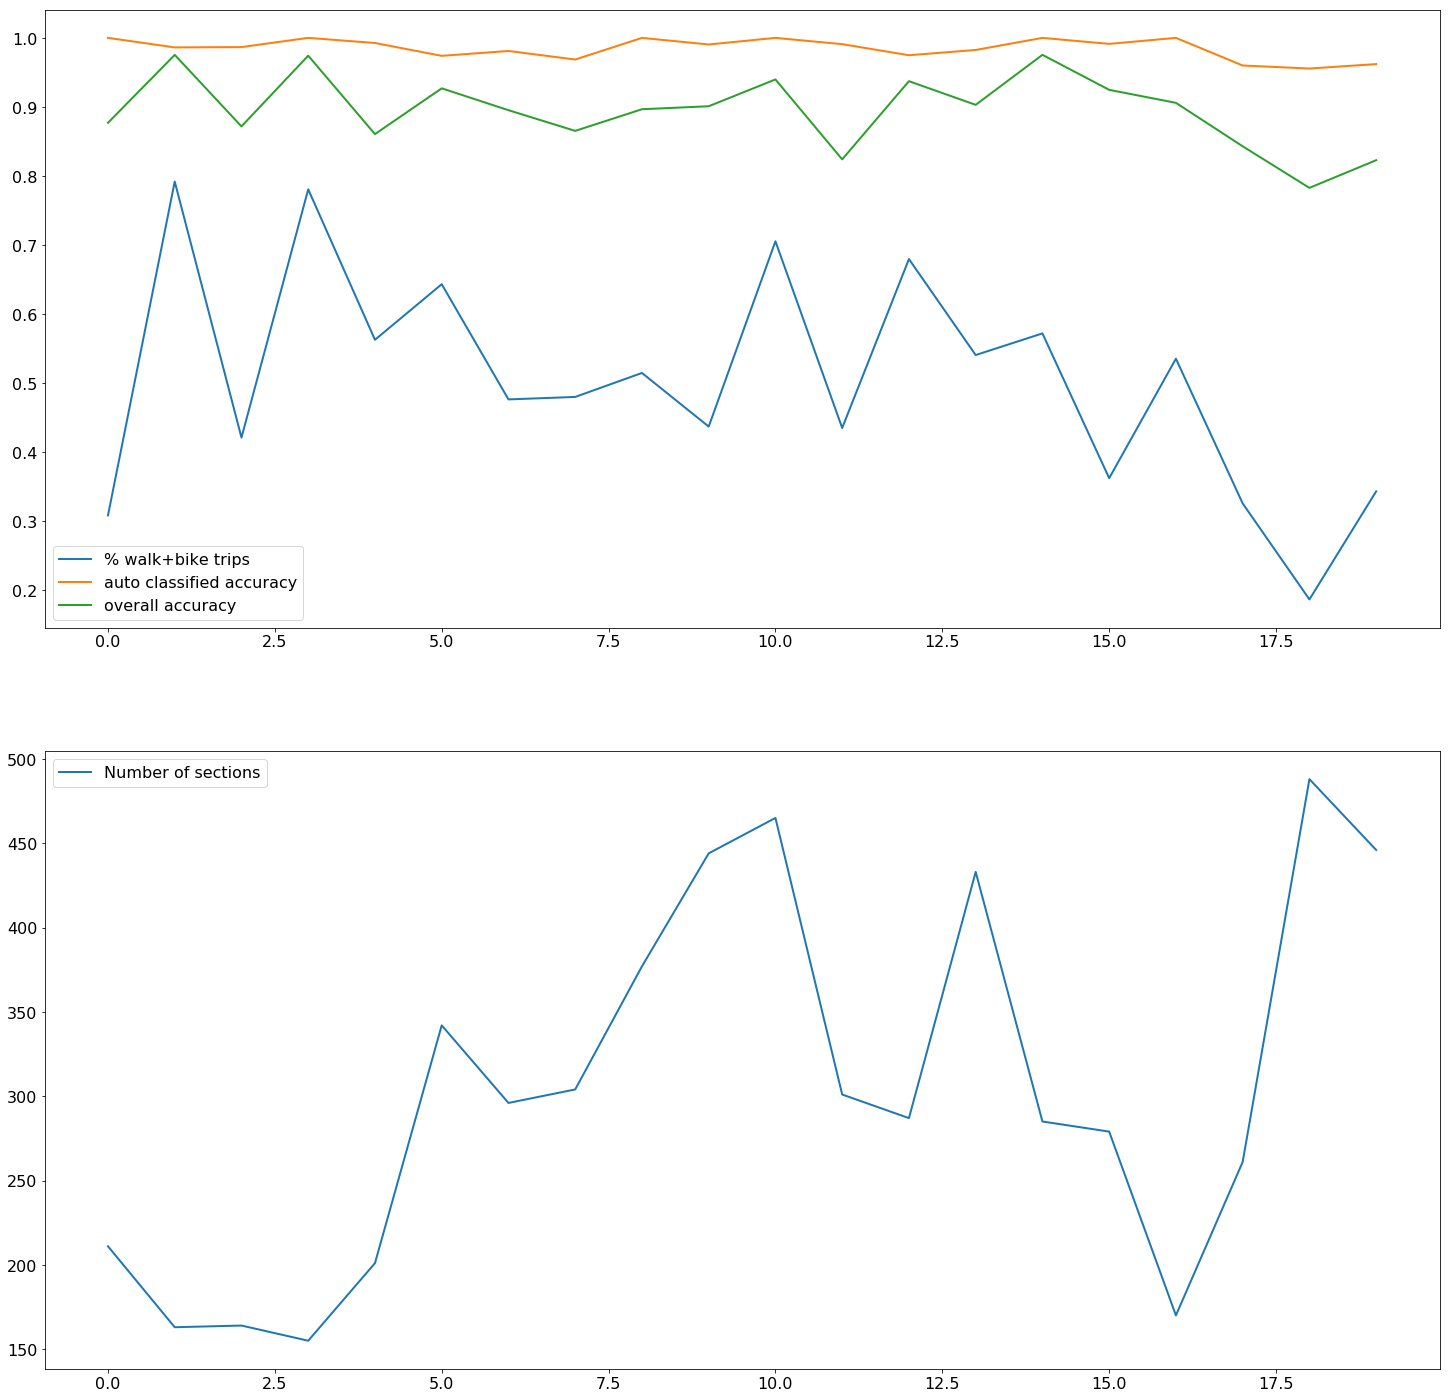

In [97]:
displayUserVariation(userIds, userResultArray, labels)

20
len(rectList) = 4, len(countLabelList) = 4
([<matplotlib.lines.Line2D object at 0x120966240>, <matplotlib.lines.Line2D object at 0x121128278>], ['98%', '85%'])


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


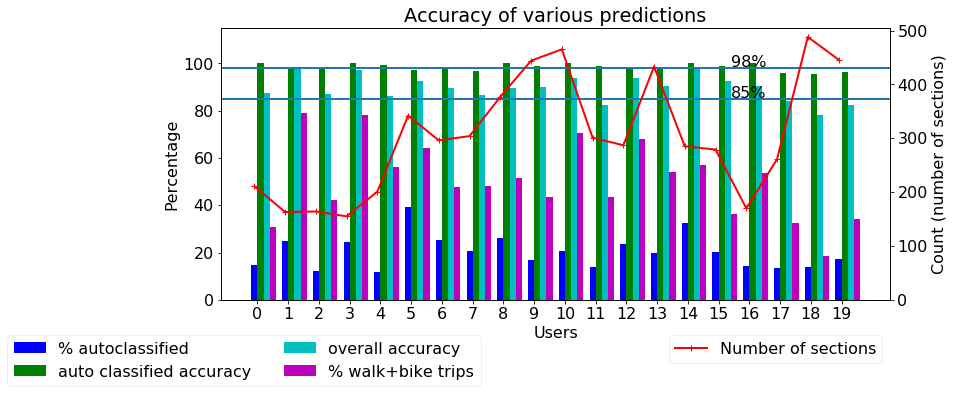

In [98]:
selIndices = [2, -2, -1, 1]
mpl.rcParams['font.size'] = 16
fig, axes = displayHelpers.showCategoryChart(np.arange(len(userIds)), np.multiply([userResultArray[i] for i in selIndices], 100), [labels[i] for i in selIndices],
                                             ['b', 'g', 'c', 'm', 'y', 'k', 'w'],
                                             "Percentage",
                                             "Accuracy of various predictions",
                                             figsize=(12,5), width=0.2)
ax2 = axes.twinx()
# ax2.bar(np.arange(len(userResultArray[0])) + 3 * 0.2, userResultArray[0], 0.2, color = 'c')
nSecLine, = ax2.plot(userResultArray[0], 'r-+', linewidth=2, label="Number of confirmed sections")
axes.set_ylim(top=115)
axes.axhline(98, linewidth=2, label = "98%")
axes.axhline(85, linewidth=2, label = "85%")
axes.text(x=15.5, y=98.5, s="98%")
axes.text(x=15.5, y=85.5, s="85%")
axes.get_legend().set_bbox_to_anchor((0.4, -0.1))
print(axes.get_legend_handles_labels())
ax2.legend([nSecLine], ["Number of sections"], loc="upper right", framealpha=0.3, bbox_to_anchor=(1, -0.1))
ax2.set_ylabel("Count (number of sections)")
axes.set_xlabel("Users")
ax2.set_ylim(bottom=0)
fig.show()

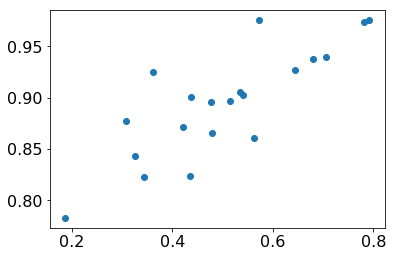

In [99]:
fig, ax = plt.subplots()
ax.plot(userResultArray[1], userResultArray[-1], "o")

Let us pick users with really high accuracy. Unfortunately, they also have the least confirmed sections. Let us see whether this is because they are heavy walkers or otherwise.

In [100]:
userIds[5], userIds[6], userIds[2]

(UUID('3537737e-8db4-3706-8c6c-ad4cafd9dc82'),
 UUID('3a307244-ecf1-3e6e-a9a7-3aaf101b40fa'),
 UUID('1cc03940-57f5-3e35-a189-55d067dc6460'))

/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


number of instances of mode 3 = 6
number of instances of mode 6 = 3
number of instances of mode 9 = 0
nClasses = 3
Number of distinct classes in training set = [ 1.  5.  7.], test set = [ 1.  5.  7.]
Number of distinct classes in training set = [ 1.  5.  7.], test set = [ 1.  5.  7.]
Number of distinct classes in training set = [ 1.  5.  7.], test set = [ 1.  5.  7.]
Number of distinct classes in training set = [ 1.  5.  7.], test set = [ 1.  5.  7.]
Number of distinct classes in training set = [ 1.  5.  7.], test set = [ 1.  5.  7.]
[[ 100.    0.    0.]
 [   3.   83.   13.]
 [   0.   35.   65.]]


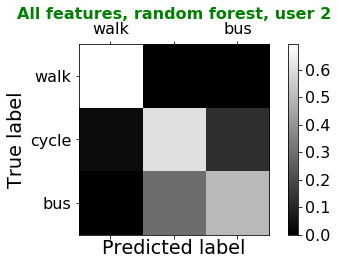

/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


number of instances of mode 6 = 1
number of instances of mode 9 = 1
nClasses = 4
Number of distinct classes in training set = [ 1.  3.  5.  7.], test set = [ 1.  3.  5.  7.]
Number of distinct classes in training set = [ 1.  3.  5.  7.], test set = [ 1.  3.  5.  7.]
Number of distinct classes in training set = [ 1.  3.  5.  7.], test set = [ 1.  3.  5.  7.]
Number of distinct classes in training set = [ 1.  3.  5.  7.], test set = [ 1.  3.  5.  7.]
Number of distinct classes in training set = [ 1.  3.  5.  7.], test set = [ 1.  3.  5.  7.]
[[ 98.   2.   0.   0.]
 [ 15.  76.   0.   9.]
 [ 10.   0.  77.  13.]
 [ 20.   7.   7.  67.]]


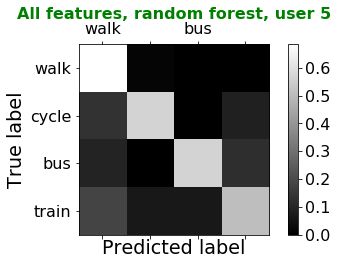

/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


number of instances of mode 5 = 9
number of instances of mode 9 = 2
nClasses = 4
Number of distinct classes in training set = [ 1.  3.  6.  7.], test set = [ 1.  3.  6.  7.]
Number of distinct classes in training set = [ 1.  3.  6.  7.], test set = [ 1.  3.  6.  7.]
Number of distinct classes in training set = [ 1.  3.  6.  7.], test set = [ 1.  3.  6.  7.]
Number of distinct classes in training set = [ 1.  3.  6.  7.], test set = [ 1.  3.  6.  7.]
Number of distinct classes in training set = [ 1.  3.  6.  7.], test set = [ 1.  3.  6.  7.]
[[ 92.   6.   3.   0.]
 [  5.  94.   0.   1.]
 [  0.   2.  96.   2.]
 [  5.  50.  10.  35.]]


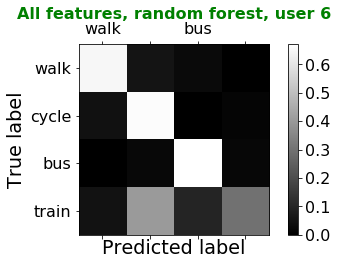

In [101]:
for i in [2,5,6]:
    userId = userIds[i]
    query = {"$and": [{'type': 'move'}, {'confirmed_mode': {'$ne': ''}}, {'user_id': userId}]}
    (userFeatureMatrix, userResultVector) = generateFeatureMatrixAndResultVector(query)
    indicesToStrip = (userResultVector == 2) | (userResultVector == 4) | (userResultVector == 8)
    for mode in [1,3,5,6,7,9]:
        # nFolds = 5
        if np.count_nonzero(userResultVector == mode) <= 10:
            print("number of instances of mode %s = %s" % (mode, np.count_nonzero(userResultVector == mode)))
            indicesToStrip = indicesToStrip | (userResultVector == mode)
    userStrippedIndices = np.logical_not(indicesToStrip)
    strippedUserFeatureMatrix = userFeatureMatrix[userStrippedIndices]
    strippedUserResultVector = userResultVector[userStrippedIndices]
    forestClf = ensemble.RandomForestClassifier()
    printConfusionMatrix(forestClf, strippedUserFeatureMatrix, strippedUserResultVector, "All features, random forest, user %s" % i)

So there's quite a bit of variability in both the overall accuracy, and in the number of trips for a user. The two don't seem to be correlated though. We get some fairly uneven improvement - for some users, the general classification is over 90%. We are also able to classify over 80% of the trips for some users.

But that might just be due to a higher ratio of walk trips, which are classified more accurately. I can explore this only for transport, but first, I'm going to try to build a gesture library and build the associated features. Then maybe Mogeng can continue some of the exploration.

In [102]:
(userIdsTransOnly, userResultArrayTransOnly, labelsTransOnly) = getUserModelComparison(isTransportOnly=True)

/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Skipping user with userId 01477d94-e0bb-3903-a428-338551801391 who has 41 unconfirmed sections
Skipping user with userId 03678a4f-efb9-3100-b0e5-8f296c197eb7 who has 82 unconfirmed sections
Skipping user with userId 04a9dec3-5a20-38ef-85b7-414dc7a2cf4e who has 0 unconfirmed sections
Skipping user with userId 1a65368b-888e-3e77-8f7c-1128f16da1df who has 22 unconfirmed sections
Skipping user with userId 1c97e50a-aa2a-3016-ad31-f9f6b726d4c4 who has 103 unconfirmed sections
Skipping user with userId 1cc03940-57f5-3e35-a189-55d067dc6460 who has 60 unconfirmed sections
Skipping user with userId 202a0732-d5c2-307d-aa29-2b39bc5e6660 who has 43 unconfirmed sections
Skipping user with userId 2491630e-bb62-39c2-8349-df4dad434dee who has 63 unconfirmed sections
Skipping user with userId 298a1c8e-74c7-3631-b59f-a5ce246c4e6d who has 68 unconfirmed sections
Skipping user with userId 3537737e-8db4-3706-8c6c-ad4cafd9dc82 who has 35 unconfirmed sections
Skipping user with userId 399ed209-2e4e-37fc-a6ac-

/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Skipping user with userId 3c1f13e8-b063-3d6c-a1eb-8fd39b874110 who has 20 unconfirmed sections
Skipping user with userId 527e98f8-710d-3719-93f2-ab140d1439ba who has 107 unconfirmed sections
Skipping user with userId 5322f635-a82c-3677-a1a4-5c26804a90b7 who has 24 unconfirmed sections
Skipping user with userId 560a0ea4-fcdf-3c1b-adf0-22d2b79af3ea who has 2 unconfirmed sections
Skipping user with userId 5c035ff1-e0d5-397f-b989-9cb8faa0a1da who has 112 unconfirmed sections
Skipping user with userId 5dd35f51-3d1a-30db-9b22-ce0a432c2a59 who has 108 unconfirmed sections
Skipping user with userId 6a488797-5be1-38aa-9700-5532be978ff9 who has 38 unconfirmed sections
Skipping user with userId 6dbe9b5a-26a1-31d0-aeb6-7b08ffa49b10 who has 0 unconfirmed sections
Skipping user with userId 7327a0b3-4959-31f5-86cb-ea0c59fd0c83 who has 8 unconfirmed sections
Skipping user with userId 7a88d272-3b9e-3d18-9749-57ddb6214440 who has 0 unconfirmed sections
Skipping user with userId 89e30222-b446-30ad-852c-b

/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Skipping user with userId 8d235d9c-7af6-3132-ba91-626e40181449 who has 5 unconfirmed sections
Skipping user with userId 8d718272-c46c-3e24-8bae-9696917deeec who has 16 unconfirmed sections
Skipping user with userId 8e230f78-6e37-3588-bf2c-6888a5b63c82 who has 15 unconfirmed sections
Skipping user with userId 951779de-a10c-3373-b186-c1c9b14b5e38 who has 1 unconfirmed sections
Found 3 high confidence predictions out of 37
Found 7 high confidence predictions out of 37
Found 8 high confidence predictions out of 37
Found 9 high confidence predictions out of 37
Found 3 high confidence predictions out of 37
for prob 0.95, percentage auto classified 0.162162162162
for prob 0.95, scoring only on high confidence predictions 0.949206349206
for prob 0.95, scoring on all predictions 0.745945945946


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Skipping user with userId 9cc9d577-3a22-3659-8cd5-9142936f44ec who has 8 unconfirmed sections
Skipping user with userId a1a10092-0136-37f1-8109-9ebf47ef72b2 who has 1 unconfirmed sections
Skipping user with userId a47da5c4-3ced-34ac-af25-6c3aa7998827 who has 119 unconfirmed sections
Skipping user with userId acd105e3-b221-35c5-81ac-fee5ffe9de66 who has 11 unconfirmed sections
Skipping user with userId adaa57a8-7fb8-3389-acce-db50ddc9e2dd who has 11 unconfirmed sections
Found 14 high confidence predictions out of 40
Found 23 high confidence predictions out of 40
Found 19 high confidence predictions out of 40
Found 18 high confidence predictions out of 40
Found 25 high confidence predictions out of 40
for prob 0.95, percentage auto classified 0.495
for prob 0.95, scoring only on high confidence predictions 0.975304347826
for prob 0.95, scoring on all predictions 0.895
Skipping user with userId b3b9fe85-d510-3e5b-bec2-031ca9da7c83 who has 0 unconfirmed sections
Skipping user with userId b

/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Skipping user with userId bd01c81f-feff-3249-a6de-5cf7f06accc8 who has 98 unconfirmed sections
Found 15 high confidence predictions out of 43
Found 13 high confidence predictions out of 43
Found 10 high confidence predictions out of 43
Found 15 high confidence predictions out of 43
Found 12 high confidence predictions out of 42
for prob 0.95, percentage auto classified 0.30365448505
for prob 0.95, scoring only on high confidence predictions 0.871282051282
for prob 0.95, scoring on all predictions 0.808084163898


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Found 15 high confidence predictions out of 64
Found 13 high confidence predictions out of 64
Found 9 high confidence predictions out of 64
Found 4 high confidence predictions out of 64
Found 5 high confidence predictions out of 64
for prob 0.95, percentage auto classified 0.14375
for prob 0.95, scoring only on high confidence predictions 0.871794871795
for prob 0.95, scoring on all predictions 0.696875


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Skipping user with userId d8a6b737-b6a5-3fc7-a144-76ac2d434252 who has 12 unconfirmed sections
Skipping user with userId e0509a4e-9842-3c73-8050-875b6383c097 who has 22 unconfirmed sections
Skipping user with userId e1a99120-9a5a-31ae-9d7a-93b9a3e0c51c who has 23 unconfirmed sections
Skipping user with userId e211dd91-423f-31ff-a1f8-89e5fdecc164 who has 54 unconfirmed sections
Skipping user with userId ea3f7719-f4a3-36fd-9477-924114cfe0bd who has 8 unconfirmed sections
Skipping user with userId ed8ca6a2-9092-37af-adde-46e51a18a310 who has 29 unconfirmed sections
Found 5 high confidence predictions out of 45
Found 11 high confidence predictions out of 45
Found 8 high confidence predictions out of 44
Found 7 high confidence predictions out of 44
Found 16 high confidence predictions out of 44
for prob 0.95, percentage auto classified 0.21202020202
for prob 0.95, scoring only on high confidence predictions 0.903246753247
for prob 0.95, scoring on all predictions 0.689191919192


/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/shankari/e-mission/e-mission-analysis/featurecalc.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if speeds == None:
/Users/shankari/OSS/anaconda/envs/emission/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Skipping user with userId f8fee20c-0f32-359d-ba75-bce97a7ac83b who has 67 unconfirmed sections
Skipping user with userId fb457463-9a06-3c84-947d-db1fefb5a199 who has 0 unconfirmed sections
Skipping user with userId ff860db0-f3fe-387c-a005-c5837f5ba970 who has 0 unconfirmed sections
(9, 7)


[ 0.  1.  0.  0.  0.  0.  0.]
[ 1.  1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.  1.]
[ 170.  255.  185.  200.  214.  320.  222.]


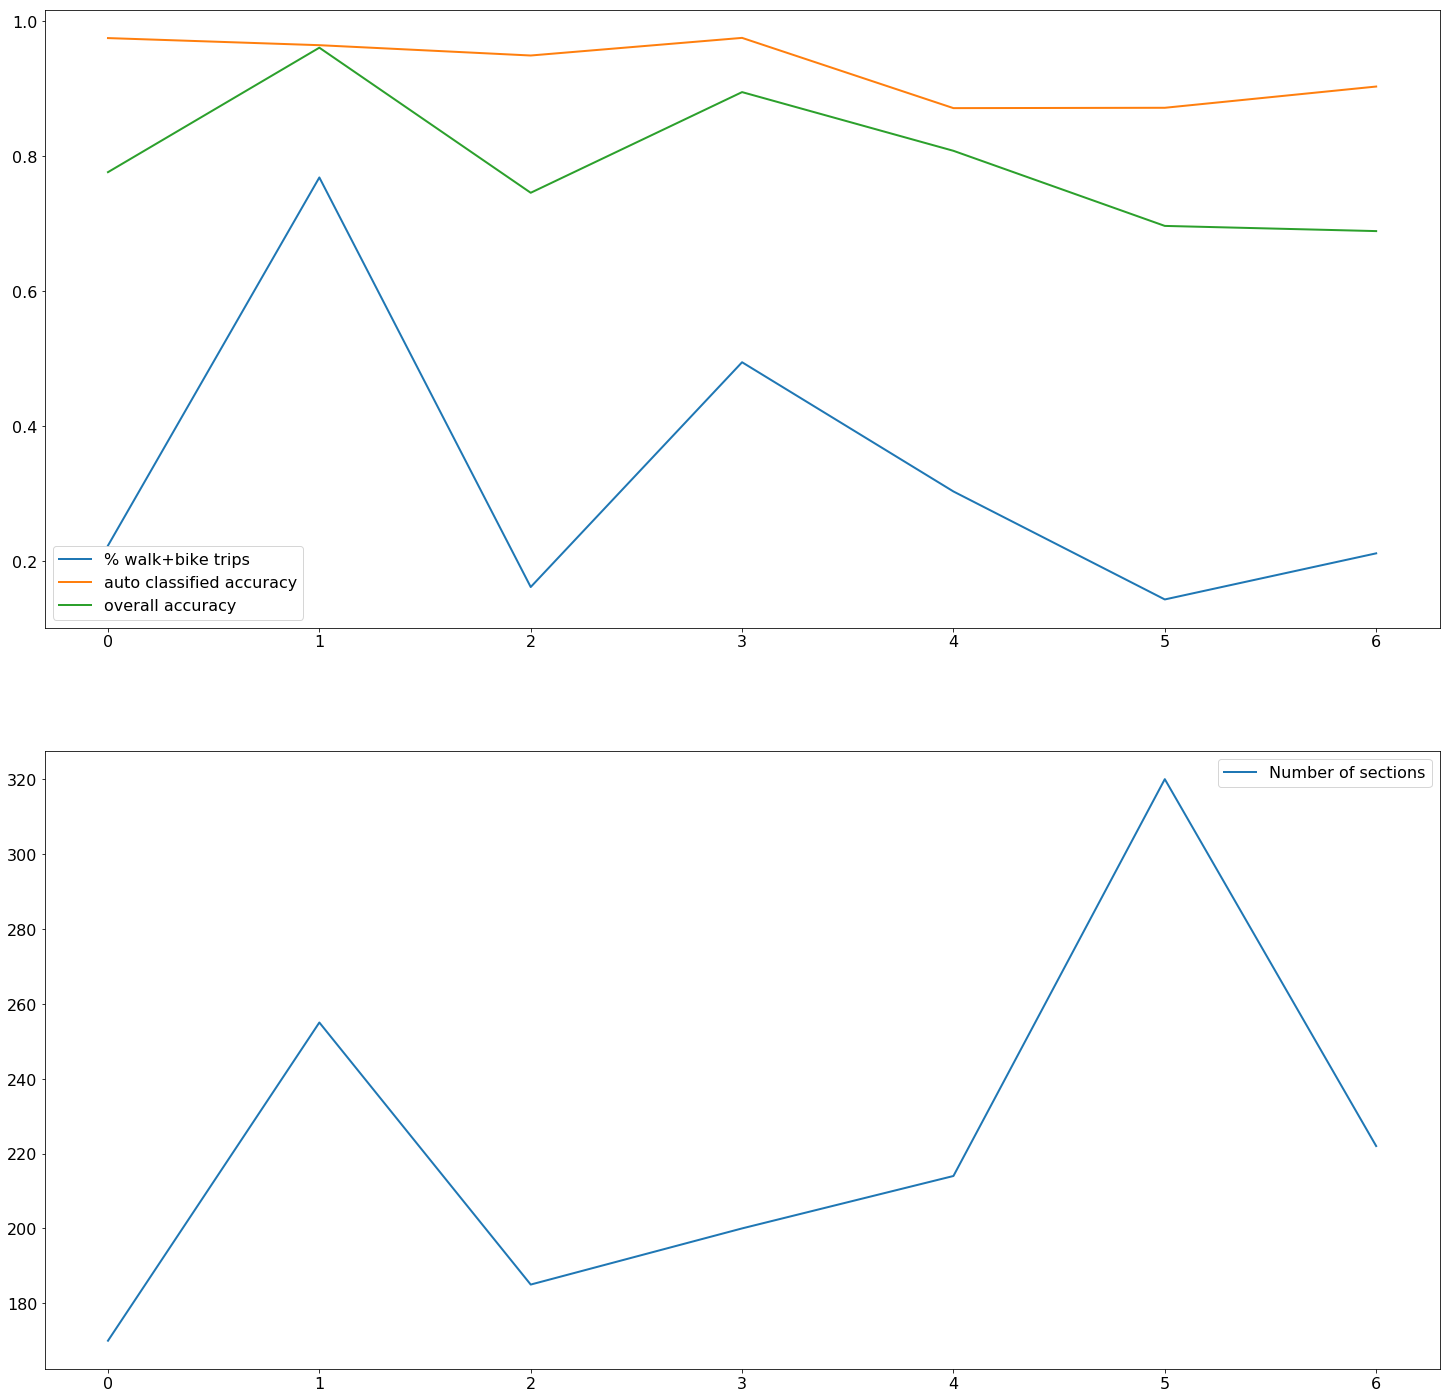

In [103]:
displayUserVariation(userIdsTransOnly, userResultArrayTransOnly, labelsTransOnly)

So looking at transport-only trips, and focusing on users with enough transport history (50+ motorized transport trips), we are able to get an overall accuracy of around 70 - 80% even for the motorized trips. However, there are some clear outliers, like the one who has only 60% accuracy. Also, because our current threshold for high confidence is set so high, the high confidence predictions are > 95% correct as before. We have to decide what to use.

We can autoclassify 20 - 50% of the motorized transport trips. In general, this is related to the number of trips - there is a very clear spike in the data for user 4. But the correlation is not exact. In particular, user 5 has > 50 trips, but only ~ 10% autoclassified trips.

It might be worthwhile to take a closer look at these 6 users, see what their transport trips look like, and get a sense of what the difference between user 4 and user 5 is, for example. This might help us figure out how to build better user models.

In [104]:
def buildRouteLibrary(userId, threshold):
    '''
    Here we attempt to build a route library for each user.
    Then, the probability of the top match can be a factor in our machine learning.
    Let us just start with the start and end points instead of a full dynamic time warp.
    
    userSections = Sections.find({"$and": [{'type': 'move'}, {'confirmed_mode': {'$ne': ''}}, {'user_id': userId}]})
    existingRoutes = RouteLibrary()
    for section in userSections:
        existingRoutes.update(section)
    return existingRoutes
    '''

## A summary comparision of models

In [105]:
modelCMList = []
saveDir = "/tmp/ml_results/"

In [106]:
import os
os.makedirs(saveDir, exist_ok=True)

### Generic model

Found 775 high confidence predictions out of 1462
Found 767 high confidence predictions out of 1462
Found 795 high confidence predictions out of 1461
Found 775 high confidence predictions out of 1461
Found 768 high confidence predictions out of 1461
for prob 0.9, percentage auto classified 0.530998669464
for prob 0.9, scoring only on high confidence predictions 0.97479037712
for prob 0.9, scoring on all predictions 0.852607091258
Found 752 high confidence predictions out of 1462
Found 736 high confidence predictions out of 1462
Found 775 high confidence predictions out of 1461
Found 750 high confidence predictions out of 1461
Found 770 high confidence predictions out of 1461
for prob 0.95, percentage auto classified 0.517725149369
for prob 0.95, scoring only on high confidence predictions 0.976978396342
for prob 0.95, scoring on all predictions 0.85206073834
Found 741 high confidence predictions out of 1462
Found 750 high confidence predictions out of 1462
Found 777 high confidence pre

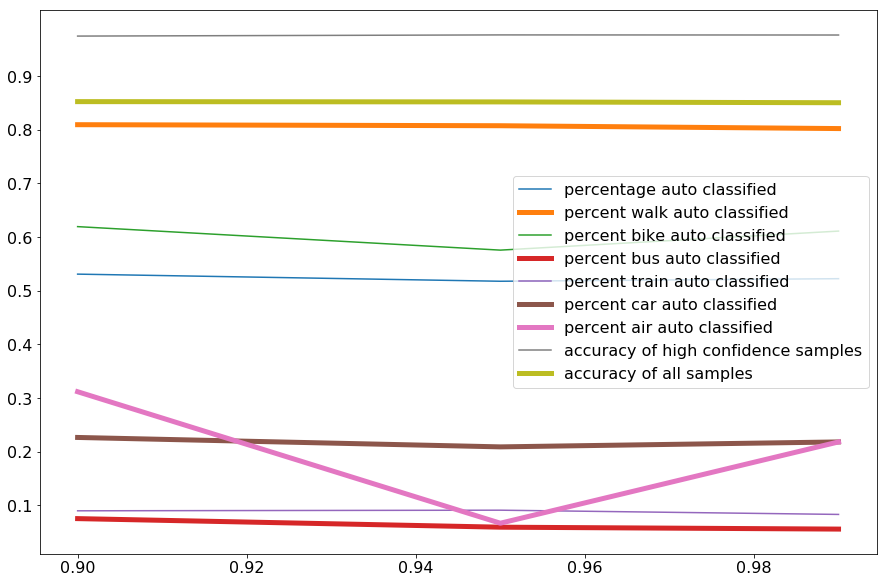

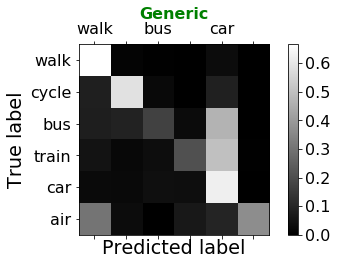

In [107]:
forestClf = ensemble.RandomForestClassifier()
exploreKFoldValidationSpace(forestClf, cleanedFeatureMatrix[:,genericFeatureIndices], cleanedResultVector, 5)
currCM, fig = printConfusionMatrix(forestClf, cleanedFeatureMatrix[:,genericFeatureIndices], cleanedResultVector, "Generic")
modelCMList.append(currCM)
fig.savefig(saveDir+"cm_generic.png", bbox_inches="tight")

### Generic + Advanced model

Found 741 high confidence predictions out of 1462
Found 741 high confidence predictions out of 1462
Found 696 high confidence predictions out of 1461
Found 709 high confidence predictions out of 1461
Found 740 high confidence predictions out of 1461
for prob 0.9, percentage auto classified 0.496370475032
for prob 0.9, scoring only on high confidence predictions 0.976568239712
for prob 0.9, scoring on all predictions 0.857396738362
Found 714 high confidence predictions out of 1462
Found 742 high confidence predictions out of 1462
Found 703 high confidence predictions out of 1461
Found 717 high confidence predictions out of 1461
Found 721 high confidence predictions out of 1461
for prob 0.95, percentage auto classified 0.492266133329
for prob 0.95, scoring only on high confidence predictions 0.975872518129
for prob 0.95, scoring on all predictions 0.856304032525
Found 721 high confidence predictions out of 1462
Found 737 high confidence predictions out of 1462
Found 741 high confidence p

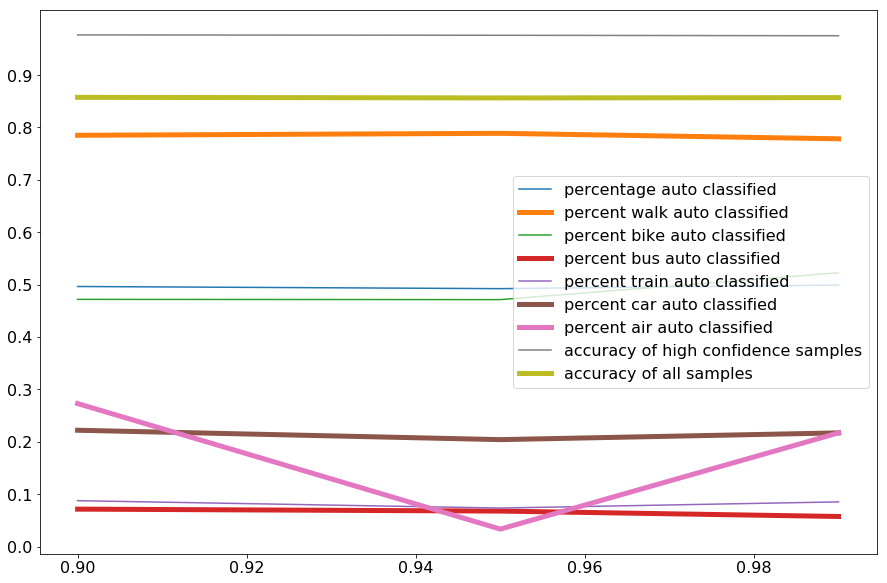

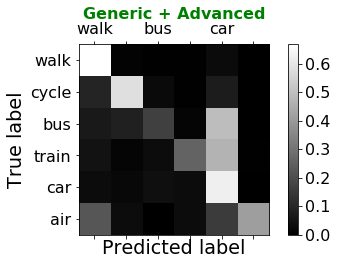

In [108]:
forestClf = ensemble.RandomForestClassifier()
exploreKFoldValidationSpace(forestClf, cleanedFeatureMatrix[:,genericFeatureIndices+AdvancedFeatureIndices], cleanedResultVector, 5)
currCM, fig = printConfusionMatrix(forestClf, cleanedFeatureMatrix[:,genericFeatureIndices+AdvancedFeatureIndices], cleanedResultVector, "Generic + Advanced")
modelCMList.append(currCM)
fig.savefig(saveDir+"cm_generic_advanced.png", bbox_inches="tight")

### Generic + Advanced + Location model

Found 741 high confidence predictions out of 1462
Found 797 high confidence predictions out of 1462
Found 762 high confidence predictions out of 1461
Found 721 high confidence predictions out of 1461
Found 753 high confidence predictions out of 1461
for prob 0.9, percentage auto classified 0.516488434828
for prob 0.9, scoring only on high confidence predictions 0.98668175697
for prob 0.9, scoring on all predictions 0.885315606592
Found 749 high confidence predictions out of 1462
Found 770 high confidence predictions out of 1462
Found 768 high confidence predictions out of 1461
Found 743 high confidence predictions out of 1461
Found 738 high confidence predictions out of 1461
for prob 0.95, percentage auto classified 0.515668858633
for prob 0.95, scoring only on high confidence predictions 0.982000476172
for prob 0.95, scoring on all predictions 0.883260252193
Found 741 high confidence predictions out of 1462
Found 797 high confidence predictions out of 1462
Found 756 high confidence pr

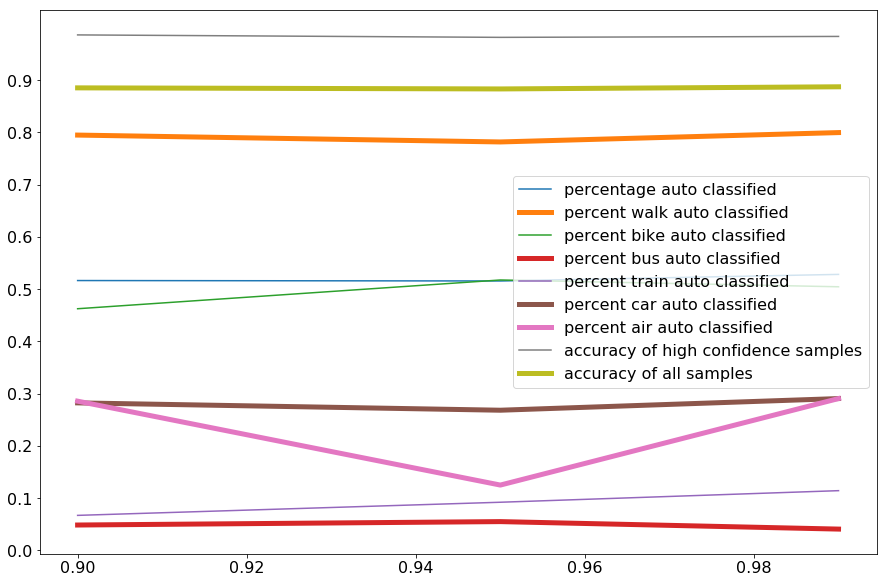

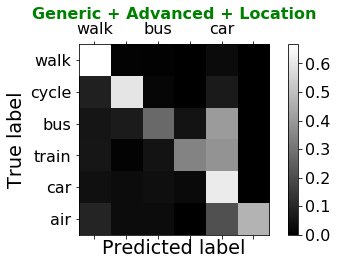

In [109]:
forestClf = ensemble.RandomForestClassifier()
exploreKFoldValidationSpace(forestClf, cleanedFeatureMatrix[:,genericFeatureIndices+AdvancedFeatureIndices
                                                            +LocationFeatureIndices], cleanedResultVector, 5)
currCM, fig = printConfusionMatrix(forestClf, cleanedFeatureMatrix[:,genericFeatureIndices+AdvancedFeatureIndices
                                                            +LocationFeatureIndices], cleanedResultVector, "Generic + Advanced + Location")
modelCMList.append(currCM)
fig.savefig(saveDir+"cm_generic_advanced_location.png", bbox_inches="tight")

### Generic + BusTrain model

Found 730 high confidence predictions out of 1462
Found 743 high confidence predictions out of 1462
Found 749 high confidence predictions out of 1461
Found 708 high confidence predictions out of 1461
Found 749 high confidence predictions out of 1461
for prob 0.9, percentage auto classified 0.503489729782
for prob 0.9, scoring only on high confidence predictions 0.978069859927
for prob 0.9, scoring on all predictions 0.853976578454
Found 755 high confidence predictions out of 1462
Found 764 high confidence predictions out of 1462
Found 716 high confidence predictions out of 1461
Found 734 high confidence predictions out of 1461
Found 729 high confidence predictions out of 1461
for prob 0.95, percentage auto classified 0.506086380878
for prob 0.95, scoring only on high confidence predictions 0.978197794524
for prob 0.95, scoring on all predictions 0.853563372725
Found 769 high confidence predictions out of 1462
Found 723 high confidence predictions out of 1462
Found 748 high confidence p

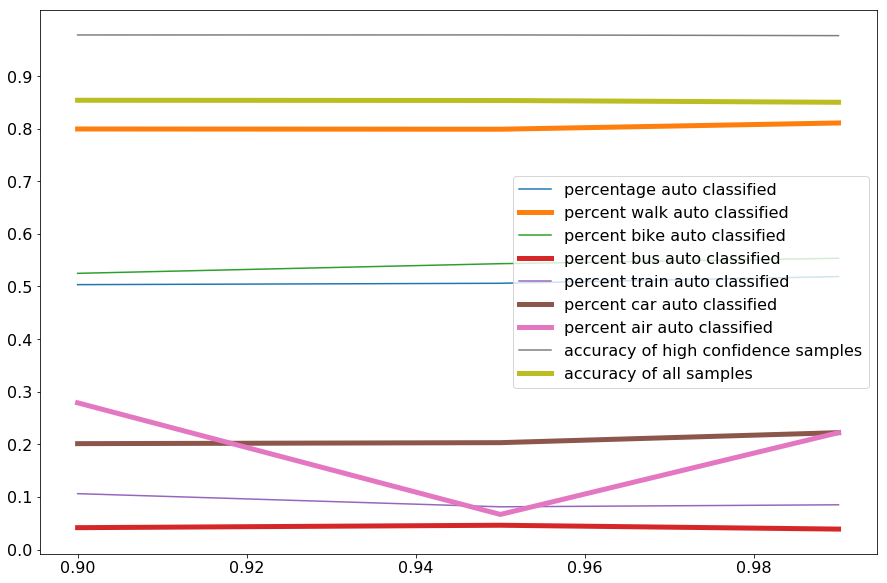

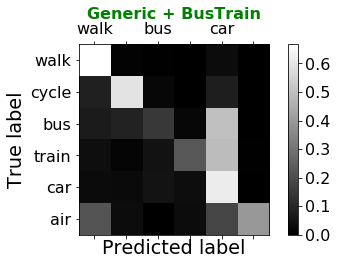

In [110]:
forestClf = ensemble.RandomForestClassifier()
exploreKFoldValidationSpace(forestClf, cleanedFeatureMatrix[:,genericFeatureIndices+BusTrainFeatureIndices], cleanedResultVector, 5)
currCM, fig = printConfusionMatrix(forestClf, cleanedFeatureMatrix[:,genericFeatureIndices+BusTrainFeatureIndices], cleanedResultVector, "Generic + BusTrain")
modelCMList.append(currCM)
fig.savefig(saveDir+"cm_generic_bustrain.png", bbox_inches="tight")

### Generic + Advanced + BusTrain model

Found 729 high confidence predictions out of 1462
Found 752 high confidence predictions out of 1462
Found 700 high confidence predictions out of 1461
Found 729 high confidence predictions out of 1461
Found 790 high confidence predictions out of 1461
for prob 0.9, percentage auto classified 0.506363724039
for prob 0.9, scoring only on high confidence predictions 0.973840213762
for prob 0.9, scoring on all predictions 0.856575944928
Found 748 high confidence predictions out of 1462
Found 718 high confidence predictions out of 1462
Found 764 high confidence predictions out of 1461
Found 716 high confidence predictions out of 1461
Found 760 high confidence predictions out of 1461
for prob 0.95, percentage auto classified 0.507186483781
for prob 0.95, scoring only on high confidence predictions 0.977064777779
for prob 0.95, scoring on all predictions 0.856301691681
Found 759 high confidence predictions out of 1462
Found 696 high confidence predictions out of 1462
Found 714 high confidence p

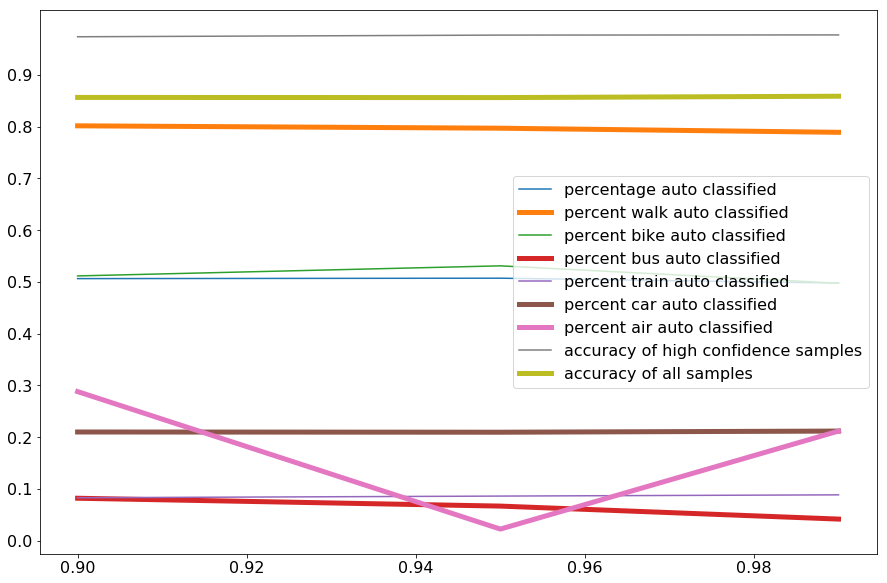

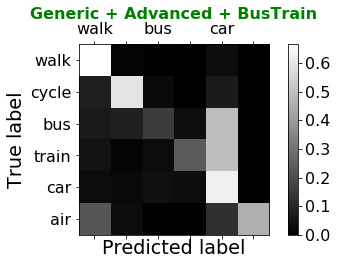

In [111]:
forestClf = ensemble.RandomForestClassifier()
exploreKFoldValidationSpace(forestClf, cleanedFeatureMatrix[:,genericFeatureIndices+AdvancedFeatureIndices+BusTrainFeatureIndices], cleanedResultVector, 5)
currCM, fig = printConfusionMatrix(forestClf, cleanedFeatureMatrix[:,genericFeatureIndices+AdvancedFeatureIndices+BusTrainFeatureIndices], cleanedResultVector, "Generic + Advanced + BusTrain")
modelCMList.append(currCM)
fig.savefig(saveDir+"cm_generic_advanced_bustrain.png", bbox_inches="tight")

### Generic + Advanced + BusTrain + Location model

Found 706 high confidence predictions out of 1462
Found 744 high confidence predictions out of 1462
Found 707 high confidence predictions out of 1461
Found 764 high confidence predictions out of 1461
Found 700 high confidence predictions out of 1461
for prob 0.9, percentage auto classified 0.495552116076
for prob 0.9, scoring only on high confidence predictions 0.983966908543
for prob 0.9, scoring on all predictions 0.884358107887
Found 739 high confidence predictions out of 1462
Found 729 high confidence predictions out of 1462
Found 754 high confidence predictions out of 1461
Found 730 high confidence predictions out of 1461
Found 803 high confidence predictions out of 1461
for prob 0.95, percentage auto classified 0.513894030942
for prob 0.95, scoring only on high confidence predictions 0.983262766583
for prob 0.95, scoring on all predictions 0.882579253945
Found 731 high confidence predictions out of 1462
Found 749 high confidence predictions out of 1462
Found 750 high confidence p

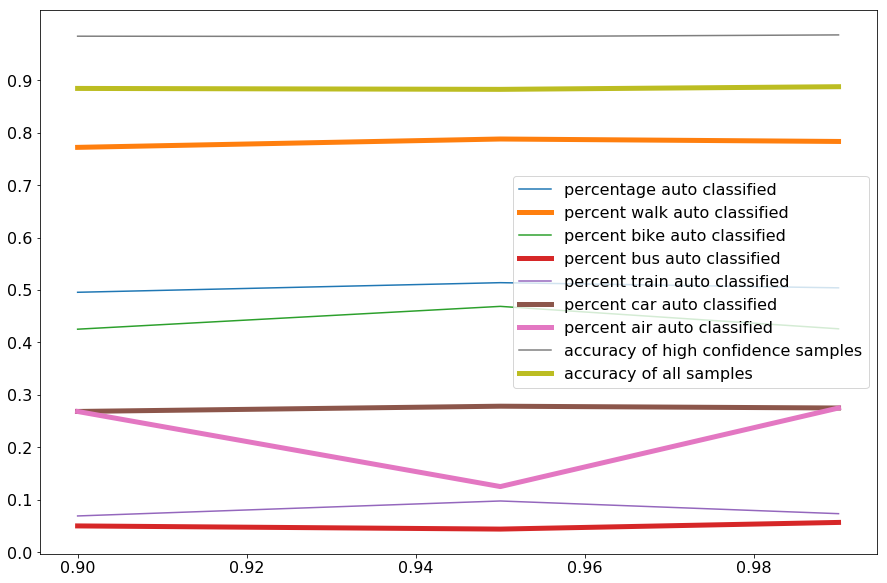

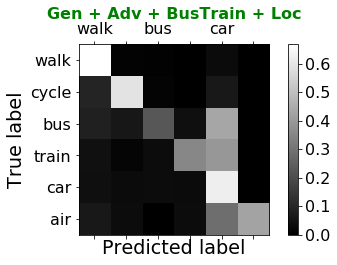

In [112]:
forestClf = ensemble.RandomForestClassifier()
exploreKFoldValidationSpace(forestClf, cleanedFeatureMatrix[:,genericFeatureIndices+AdvancedFeatureIndices+BusTrainFeatureIndices
                                                            +LocationFeatureIndices], cleanedResultVector, 5)
currCM, fig = printConfusionMatrix(forestClf, cleanedFeatureMatrix[:,genericFeatureIndices+AdvancedFeatureIndices+BusTrainFeatureIndices
                                                            +LocationFeatureIndices], cleanedResultVector, "Gen + Adv + BusTrain + Loc")
modelCMList.append(currCM)
fig.savefig(saveDir+"cm_generic_advanced_bustrain_location.png", bbox_inches="tight")

### Generic + Advanced + BusTrain + Location + Time model

Found 707 high confidence predictions out of 1462
Found 736 high confidence predictions out of 1462
Found 701 high confidence predictions out of 1461
Found 714 high confidence predictions out of 1461
Found 728 high confidence predictions out of 1461
for prob 0.9, percentage auto classified 0.490761532635
for prob 0.9, scoring only on high confidence predictions 0.983838138873
for prob 0.9, scoring on all predictions 0.880386913373
Found 704 high confidence predictions out of 1462
Found 721 high confidence predictions out of 1462
Found 750 high confidence predictions out of 1461
Found 719 high confidence predictions out of 1461
Found 700 high confidence predictions out of 1461
for prob 0.95, percentage auto classified 0.491858358357
for prob 0.95, scoring only on high confidence predictions 0.983652461362
for prob 0.95, scoring on all predictions 0.884632548402
Found 681 high confidence predictions out of 1462
Found 688 high confidence predictions out of 1462
Found 687 high confidence p

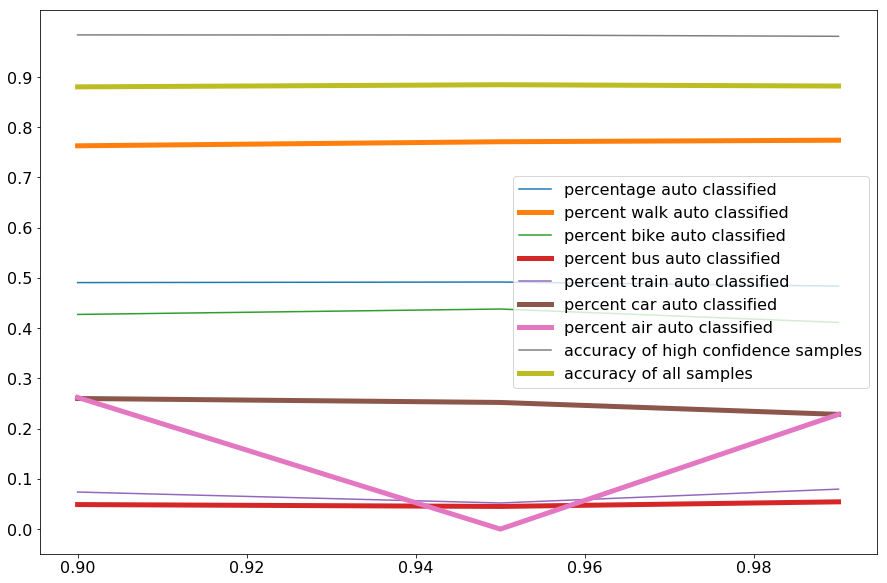

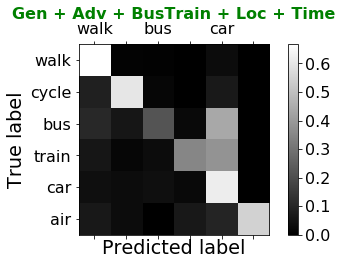

In [113]:
forestClf = ensemble.RandomForestClassifier()
exploreKFoldValidationSpace(forestClf, cleanedFeatureMatrix, cleanedResultVector, 5)
currCM, fig = printConfusionMatrix(forestClf, cleanedFeatureMatrix, cleanedResultVector, "Gen + Adv + BusTrain + Loc + Time")
modelCMList.append(currCM)
fig.savefig(saveDir+"cm_generic_advanced_bustrain_location_time.png", bbox_inches="tight")

It seems that with all the features in, we can have the best prediction result.

In [114]:
cmDiagList = []
modelLabels = ["Generic", "G+A", "G+A+L", "G+B", "G+A+B", "G+A+B+L", "G+A+B+L+T"]
for currCM in modelCMList:
    cmDiagList.append(np.diag(currCM) * 100)
accuracyMatrix = np.vstack(cmDiagList)
print(len(modelLabels), accuracyMatrix.shape)
np.set_printoptions(precision=4)
print(accuracyMatrix)
np.set_printoptions(precision=0)
print(accuracyMatrix)

7 (7, 6)
[[ 94.7508  80.0461  19.0077  23.4044  86.4984  44.6667]
 [ 95.1168  79.1115  18.2484  29.6995  86.7234  51.3333]
 [ 94.9947  82.0052  31.6051  40.8415  84.9798  60.    ]
 [ 94.9949  80.7929  16.1871  25.7268  85.1134  48.6667]
 [ 94.5984  81.2562  16.953   26.7049  86.7229  58.    ]
 [ 95.1168  81.6323  25.6876  42.4645  86.2308  53.3333]
 [ 94.9641  82.286   24.662   42.1366  85.7413  73.3333]]
[[ 95.  80.  19.  23.  86.  45.]
 [ 95.  79.  18.  30.  87.  51.]
 [ 95.  82.  32.  41.  85.  60.]
 [ 95.  81.  16.  26.  85.  49.]
 [ 95.  81.  17.  27.  87.  58.]
 [ 95.  82.  26.  42.  86.  53.]
 [ 95.  82.  25.  42.  86.  73.]]


In [115]:
cmDiagList = []
modelLabels = ["Generic", "G+A", "G+A+L", "G+B", "G+A+B", "G+A+B+L", "G+A+B+L+T"]
for currCM in modelCMList:
    cmDiagList.append(np.diag(currCM) * 100)
accuracyMatrix = np.vstack(cmDiagList).round(decimals=0).astype(object)
print(len(modelLabels), accuracyMatrix.shape)
outputMatrix = np.insert(accuracyMatrix, 0, modelLabels, axis=1)
print(outputMatrix)

7 (7, 6)
[['Generic' 95.0 80.0 19.0 23.0 86.0 45.0]
 ['G+A' 95.0 79.0 18.0 30.0 87.0 51.0]
 ['G+A+L' 95.0 82.0 32.0 41.0 85.0 60.0]
 ['G+B' 95.0 81.0 16.0 26.0 85.0 49.0]
 ['G+A+B' 95.0 81.0 17.0 27.0 87.0 58.0]
 ['G+A+B+L' 95.0 82.0 26.0 42.0 86.0 53.0]
 ['G+A+B+L+T' 95.0 82.0 25.0 42.0 86.0 73.0]]
